<a href="https://colab.research.google.com/github/rodrigojdono/Datos_indec/blob/main/Comandos_y_regresiones_para_la_tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pendientes para hablar con Ricardo:
- Como crear las tablas de descripción de variables
- Ejemplos para mapas mas visuales. Por ejemplo de gradientes de precios con diferentes colores

In [1]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 45.1 MB/s 
     |████████████████████████████████| 15.4 MB 34.9 MB/s 


# Investigando efectos del COVID en alquileres usando Diferencias en Diferencias


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Norte=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/GBANorte.csv')
Oeste=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/GBAOeste.csv')
Provincia=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datos/municipio.csv')



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unión de los df

In [5]:
GBA= pd.concat([Norte, Oeste])

In [6]:
GBA.l3.unique()

array(['Tigre', 'Escobar', 'San Miguel', nan, 'San Isidro',
       'San Fernando', 'Vicente López', 'General San Martín', 'Pilar',
       'José C Paz', 'Malvinas Argentinas', 'La Matanza',
       'Tres de Febrero', 'Moreno', 'Ituzaingó', 'General Rodríguez',
       'Merlo', 'Morón', 'Hurlingham', 'Marcos Paz'], dtype=object)

Filtro por partido

In [7]:
GBAl3=GBA.loc[(GBA.l3=='General San Martín') |(GBA.l3=='La Matanza') | (GBA.l3=='Tres de Febrero') | (GBA.l3=='José C Paz') | (GBA.l3=='Morón') | (GBA.l3=='Hurlingham') | (GBA.l3=='San Miguel') | (GBA.l3=='Ituzaingó') | (GBA.l3=='Merlo')]

Filtro por período temporal

In [8]:
import datetime

In [9]:
mask = (GBAl3['start_date'] > '2016-01-01') & (GBAl3['start_date'] <= '2020-03-30')

In [10]:
GBAl3=GBAl3.loc[mask]

In [11]:
GBAl3.groupby(by='l3').agg(['count'])

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l4,l5,l6
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
l3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
General San Martín,5899,5899,5899,5899,5899,5899,5899,5899,5899,0,5899,5899,5899,5899,3335,2327,4759,5899,5899,5899,5899,4580,5899,5899,5358,5358,5899,5899,4421,0,0
Hurlingham,675,675,675,675,675,675,675,675,675,0,675,675,675,675,159,260,430,675,675,675,675,579,675,675,623,623,675,675,292,0,0
Ituzaingó,2566,2566,2566,2566,2566,2566,2566,2566,2566,0,2566,2566,2566,2566,1455,541,2165,2566,2566,2566,2566,2143,2566,2566,2304,2304,2566,2566,1365,0,0
José C Paz,534,534,534,534,534,534,534,534,534,0,534,534,534,534,184,127,452,534,534,534,534,403,534,534,496,496,534,534,244,0,0
La Matanza,7853,7853,7853,7853,7853,7853,7853,7853,7853,0,7853,7853,7853,7853,4826,3633,6616,7853,7853,7853,7853,6252,7853,7853,6094,6094,7853,7853,7493,0,0
Merlo,1362,1362,1362,1362,1362,1362,1362,1362,1362,0,1362,1362,1362,1362,735,329,1205,1362,1362,1362,1362,1227,1362,1362,1236,1236,1362,1362,1167,0,0
Morón,4607,4607,4607,4607,4607,4607,4607,4607,4607,0,4607,4607,4607,4607,2891,1365,4068,4607,4607,4607,4607,3609,4607,4607,3806,3806,4607,4607,3951,0,0
San Miguel,5326,5326,5326,5326,5326,5326,5326,5326,5326,0,5326,5326,5326,5326,2788,1600,4855,5326,5326,5326,5326,4535,5326,5326,4935,4935,5326,5326,3930,0,0


Saco los outlier de precios

In [12]:
GBAl3.price.describe()

count    3.445100e+04
mean     1.983137e+04
std      5.126079e+04
min      6.000000e+02
25%      6.800000e+03
50%      9.500000e+03
75%      1.500000e+04
max      3.165000e+06
Name: price, dtype: float64

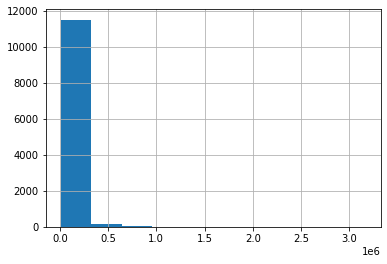

In [13]:
GBAl3.price.loc[GBAl3.price>12000].hist()

In [14]:
mask2=GBAl3['price']<80000

In [15]:
GBAl3 = GBAl3.loc[mask2]

In [16]:
maskpreciosmin=GBAl3['price']>1000

In [17]:
GBAl3 = GBAl3.loc[maskpreciosmin]

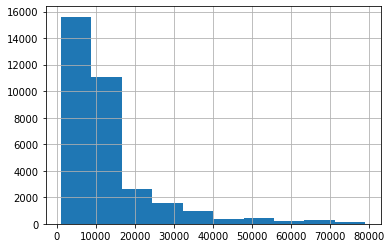

In [18]:
GBAl3.price.hist()

Mapeo para decribir y pasarlo al [documento ](https://docs.google.com/document/d/1VJ6k-7QZ1TBv2OVukg40SKI3lOQuEdxa_EAepgDTByA/edit)

In [19]:
limites=gpd.read_file("https://github.com/rpasquini/urban-econometrics/blob/master/data/ign_departamento.zip?raw=true")

fig, ax = plt.subplots(figsize=(15, 15))
provincia.to_crs("EPSG:4326").plot(ax=ax)
gdf.to_crs("EPSG:4326").plot(ax=ax,color='orange')
ax.set_xlim(-59, -58)
ax.set_ylim(-35, -34.1)

Filtro por l3 vacio y luego por barrio

In [20]:
GBAl3null=GBAl3[GBAl3["l3"].isnull()]

In [21]:
GBAl3null

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l3,l4,l5,l6


In [22]:
GBAl3null.l5.unique()

array([], dtype=object)

Voy a crear la variable de distancia al aeropuerto

In [23]:
crs_ciudad={'proj': 'tmerc',
 'lat_0': -34.6297166,
 'lon_0': -58.4627,
 'k': 0.999998,
 'x_0': 100000,
 'y_0': 100000,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True}


Buscar función que convierte a Gdf. (GEOPANDAS)

In [24]:
geometry = [Point(xy) for xy in zip(GBAl3.lon, GBAl3.lat)]
gdf=gpd.GeoDataFrame(GBAl3, crs=4326, geometry=geometry)

In [25]:
gdf.crs = {'init' :'epsg:4326'}

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [26]:
gdf=gdf.to_crs(crs_ciudad)

In [27]:
aeropuerto = gpd.GeoDataFrame({'col1': ['name1'], 'geometry': [Point(-58.612500,-34.610000)]}, crs={'init' :'epsg:4326'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [28]:
aeropuerto=aeropuerto.to_crs(crs_ciudad)

In [29]:
def distancia(row):
    return aeropuerto.geometry[0].distance(row['geometry'])

In [30]:
gdf['distanciaPAL']=gdf.apply(distancia,axis=1)

In [31]:
gdf.distanciaPAL.head()

2      9493.979199
17    10783.064719
20     6914.387727
33     7637.476177
34     7691.734708
Name: distanciaPAL, dtype: float64

In [32]:
gdf.distanciaPAL.describe()

count     3.324600e+04
mean               inf
std                inf
min       1.022074e+03
25%       5.815770e+03
50%       8.536477e+03
75%       1.195953e+04
max      1.797693e+308
Name: distanciaPAL, dtype: float64

Saco los outlier de distancia a partir de los 20.000

In [33]:
Outlierdistancia=gdf['distanciaPAL']<20000

In [34]:
gdf=gdf[Outlierdistancia]

In [35]:
gdf.distanciaPAL.describe()

count    28429.000000
mean      8073.707509
std       3154.098167
min       1022.073997
25%       5455.507204
50%       7796.658939
75%      10208.090167
max      19967.989299
Name: distanciaPAL, dtype: float64

(-35.0, -34.1)

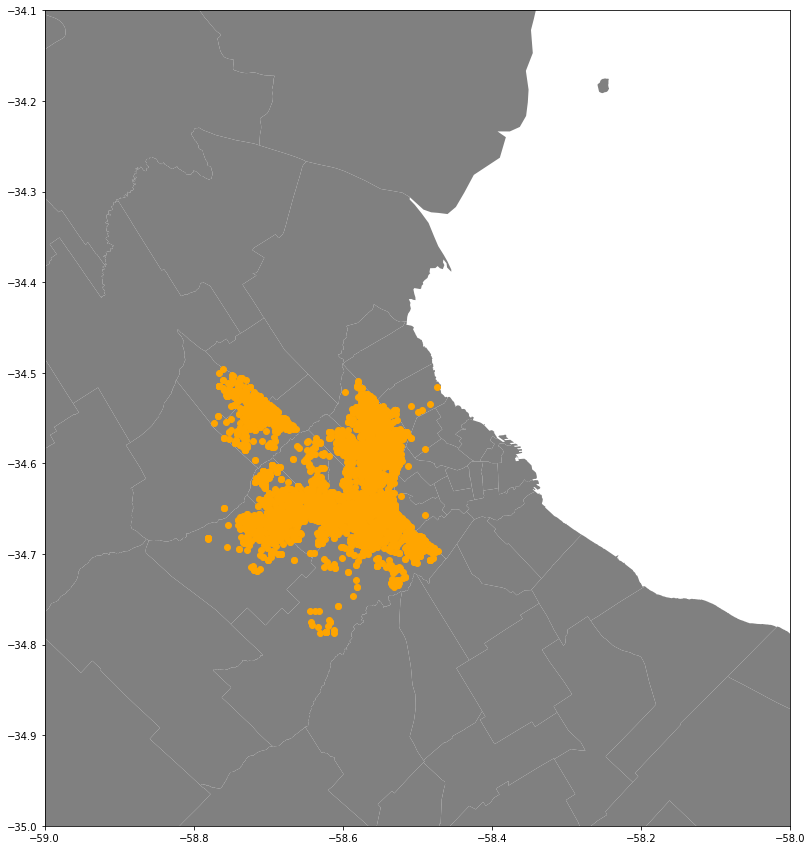

In [301]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax,color='grey')
gdf.to_crs("EPSG:4326").plot(ax=ax,color='orange')
ax.set_xlim(-59, -58)
ax.set_ylim(-35, -34.1)

Voy a crear la variable precio x m2

In [37]:
gdf.groupby(by='l3').surface_total.describe()

,count,mean,std,min,25%,50%,75%,max
l3,,,,,,,,
General San Martín,4972.0,183.271722,787.550168,10.0,45.0,60.0,116.0,17150.0
Hurlingham,542.0,686.121771,1593.162597,13.0,45.0,90.0,300.0,18000.0
Ituzaingó,2256.0,201.808954,480.604106,10.0,44.0,75.0,200.0,14542.0
José C Paz,442.0,192.592760,750.382761,12.0,35.0,48.0,120.0,10000.0
La Matanza,5830.0,133.419039,713.781888,10.0,40.0,54.0,90.0,46000.0
Merlo,1219.0,120.994258,428.735912,11.0,38.0,53.0,90.0,10000.0
Morón,3744.0,125.486111,889.658268,10.0,35.0,45.0,75.0,45000.0
San Miguel,4798.0,140.432889,1603.373907,12.0,38.0,45.0,70.0,58806.0
Tres de Febrero,4626.0,113.550151,426.532333,10.0,37.0,48.0,73.0,22610.0


Saco los outliers de baños

In [38]:
Outlierbathrooms=gdf['bathrooms']<10

In [39]:
gdf=gdf[Outlierbathrooms]

In [40]:
gdf.bathrooms.describe()

count    24367.000000
mean         1.184922
std          0.525659
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          9.000000
Name: bathrooms, dtype: float64

#Saco los outliers de superficie

In [41]:
Outliersuperficie=gdf['surface_total']<120

In [42]:
gdf=gdf[Outliersuperficie]

In [43]:
gdf.surface_total.describe()

count    20662.000000
mean        50.959104
std         20.695240
min         10.000000
25%         36.000000
50%         45.000000
75%         60.000000
max        119.000000
Name: surface_total, dtype: float64

#Saco los outliers de rooms

In [44]:
Outliersrooms=gdf['rooms']<23

In [45]:
gdf=gdf[Outliersrooms]

In [46]:
gdf.rooms.describe()

count    14049.000000
mean         2.085202
std          0.787729
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: rooms, dtype: float64

In [47]:
gdf['precioxm2']=((gdf.price)/(gdf.surface_total))

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
gdf.precioxm2.describe()

count    14049.000000
mean       190.251298
std         86.756332
min         31.250000
25%        138.297872
50%        181.818182
75%        227.272727
max       3260.869565
Name: precioxm2, dtype: float64

In [49]:
gdf.groupby(by='l3').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
l3,,,,,,,,
General San Martín,2618.0,178.491852,83.480703,31.818182,122.222222,170.000000,222.222222,1454.545455
Hurlingham,99.0,201.170311,70.519952,73.684211,155.555556,196.969697,250.000000,530.000000
Ituzaingó,852.0,203.369936,93.934402,50.000000,147.826087,191.421569,242.953668,1041.666667
José C Paz,155.0,192.215065,56.256586,83.333333,150.000000,200.000000,225.000000,380.000000
La Matanza,2819.0,192.926105,78.454765,36.363636,141.176471,183.333333,231.707317,1000.000000
Merlo,553.0,191.169419,85.435417,31.250000,130.000000,181.818182,237.500000,789.473684
Morón,1937.0,205.944264,109.585537,40.000000,155.000000,197.916667,239.583333,3260.869565
San Miguel,2233.0,208.273619,83.090094,60.000000,166.666667,200.000000,236.111111,1764.705882
Tres de Febrero,2783.0,168.524624,75.651404,37.500000,120.000000,160.000000,203.464755,2000.000000


Creo la variable precio en logaritmo.

In [50]:
gdf.head()

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l3,l4,l5,l6,geometry,distanciaPAL,precioxm2
2,5,Propiedad,Propiedad,Argentina,b'\x07\x11\xf3\xb8~\xdb\x0f \xfc\x0f>>\x18\xd7...,2018-01-23,2018-03-01,2018-01-23,"{'lat': -34.5495042, 'lon': -58.6856867, 'l1':...",NaN,Alquiler,Alquiler,Casa,Casa,3.0,2.0,2.0,70,70,9500,ARS,Mensual,Dplex con dos dormitorios + altillo en alquiler,Dplex con dos dormitorios + altillo en alquile...,-34.549504,-58.685687,Argentina,Bs.As. G.B.A. Zona Norte,San Miguel,Bella Vista,NaN,NaN,POINT (79532.142 108875.822),9493.979199,135.714286
17,60,Propiedad,Propiedad,Argentina,b'%\xa1\xbcoq\x94Z\xca\x89\xad\xa4\xa5\xa3<\x9c2',2017-11-05,2018-03-25,2017-11-05,"{'lat': -34.517044, 'lon': -58.578155, 'l1': '...",NaN,Alquiler,Alquiler,PH,PH,1.0,1.0,1.0,31,31,3500,ARS,Mensual,Alquiler monoambiente Jose L Suarez,Corredor Responsable: Uno Bienes Raices SRL - ...,-34.517044,-58.578155,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Jose Leon Suarez,NaN,NaN,POINT (89398.327 112493.315),10783.064719,112.903226
33,119,Propiedad,Propiedad,Argentina,b'\x07\xf9\xbb*CD\x81\xa7dq\x1a\x00\x1elg\x97',2016-06-20,2016-07-28,2016-06-20,"{'lat': -34.5553622, 'lon': -58.5618564, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,2.0,1.0,1.0,50,40,6000,ARS,Mensual,Depto T/casa de 2 ambientes - 2 COCHERAS,DEPARTAMENTO TIPO CASA AL FRENTE<br>Living Com...,-34.555362,-58.561856,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (90899.119 108244.086),7637.476177,120.000000
34,120,Propiedad,Propiedad,Argentina,b'\xd8\x1a|\x11\xaed\xde\x8a&\n\xad-\xc2\x12\x...,2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,38,36,4000,ARS,Mensual,depto 2 amb,depto 2 amb. 2 piso al contrafrente<br>cuenta ...,-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,105.263158
35,121,Propiedad,Propiedad,Argentina,b'\xdd+\xaf\xa7\x96\xb8J\xfeI\xa8g}\xdfX\x84e',2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,47,42,4800,ARS,Mensual,depto 2 amb,"Depto al contrafrente, cuenta con cocina comed...",-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,102.127660


In [51]:
gdf['logprice']=np.log(gdf.price)
gdf['logprecioxm2']=np.log(gdf.price/gdf.surface_total)

Crear Variable InicioEPA

In [52]:
gdf['InicioEPA']=np.where((gdf.start_date >'2018-01-08') ,1,0)

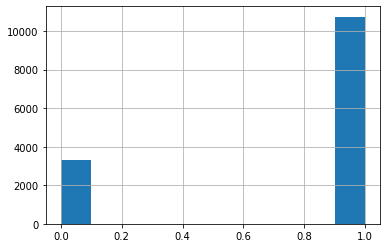

In [53]:
gdf.InicioEPA.hist()

Conclusión: Hay más casos posteriores al EPA que previos

Voy a crear la dummy para las propiedades que sean impactadas por el ruido cercano al EPA

In [54]:
gdf['Ruido']=np.where((gdf['distanciaPAL']<2500),1,0)

Creo las dummy de los anillos

In [55]:
gdf['Primer_anillo']=np.where((gdf['distanciaPAL']<5500),1,0)

In [56]:
gdf['Segundo_anillo']=np.where((gdf['distanciaPAL']>=5500) & (gdf['distanciaPAL']<10000),1,0)

In [57]:
gdf['Tercer_anillo']=np.where((gdf['distanciaPAL']>=10000) & (gdf['distanciaPAL']<20000),1,0)

In [58]:
gdf.groupby(by='l3').Primer_anillo.sum()

l3
General San Martín      73
Hurlingham              98
Ituzaingó               51
José C Paz               0
La Matanza             222
Merlo                    0
Morón                 1574
San Miguel               0
Tres de Febrero       1863
Name: Primer_anillo, dtype: int64

Descripción de variables en toda la muestra

In [59]:
gdf.groupby(by='l3').agg(['count'])

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l4,l5,l6,geometry,distanciaPAL,precioxm2,logprice,logprecioxm2,InicioEPA,Ruido,Primer_anillo,Segundo_anillo,Tercer_anillo
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
l3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
General San Martín,2618,2618,2618,2618,2618,2618,2618,2618,2618,0,2618,2618,2618,2618,2618,1591,2618,2618,2618,2618,2618,2102,2618,2618,2618,2618,2618,2618,1865,0,0,2618,2618,2618,2618,2618,2618,2618,2618,2618,2618
Hurlingham,99,99,99,99,99,99,99,99,99,0,99,99,99,99,99,43,99,99,99,99,99,83,99,99,99,99,99,99,24,0,0,99,99,99,99,99,99,99,99,99,99
Ituzaingó,852,852,852,852,852,852,852,852,852,0,852,852,852,852,852,201,852,852,852,852,852,711,852,852,852,852,852,852,448,0,0,852,852,852,852,852,852,852,852,852,852
José C Paz,155,155,155,155,155,155,155,155,155,0,155,155,155,155,155,58,155,155,155,155,155,127,155,155,155,155,155,155,57,0,0,155,155,155,155,155,155,155,155,155,155
La Matanza,2819,2819,2819,2819,2819,2819,2819,2819,2819,0,2819,2819,2819,2819,2819,2202,2819,2819,2819,2819,2819,2220,2819,2819,2819,2819,2819,2819,2675,0,0,2819,2819,2819,2819,2819,2819,2819,2819,2819,2819
Merlo,553,553,553,553,553,553,553,553,553,0,553,553,553,553,553,155,553,553,553,553,553,486,553,553,553,553,553,553,476,0,0,553,553,553,553,553,553,553,553,553,553
Morón,1937,1937,1937,1937,1937,1937,1937,1937,1937,0,1937,1937,1937,1937,1937,692,1937,1937,1937,1937,1937,1582,1937,1937,1937,1937,1937,1937,1681,0,0,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937
San Miguel,2233,2233,2233,2233,2233,2233,2233,2233,2233,0,2233,2233,2233,2233,2233,1038,2233,2233,2233,2233,2233,1825,2233,2233,2233,2233,2233,2233,1633,0,0,2233,2233,2233,2233,2233,2233,2233,2233,2233,2233


In [60]:
gdf.head()

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l3,l4,l5,l6,geometry,distanciaPAL,precioxm2,logprice,logprecioxm2,InicioEPA,Ruido,Primer_anillo,Segundo_anillo,Tercer_anillo
2,5,Propiedad,Propiedad,Argentina,b'\x07\x11\xf3\xb8~\xdb\x0f \xfc\x0f>>\x18\xd7...,2018-01-23,2018-03-01,2018-01-23,"{'lat': -34.5495042, 'lon': -58.6856867, 'l1':...",NaN,Alquiler,Alquiler,Casa,Casa,3.0,2.0,2.0,70,70,9500,ARS,Mensual,Dplex con dos dormitorios + altillo en alquiler,Dplex con dos dormitorios + altillo en alquile...,-34.549504,-58.685687,Argentina,Bs.As. G.B.A. Zona Norte,San Miguel,Bella Vista,NaN,NaN,POINT (79532.142 108875.822),9493.979199,135.714286,9.159047,4.910552,1,0,0,1,0
17,60,Propiedad,Propiedad,Argentina,b'%\xa1\xbcoq\x94Z\xca\x89\xad\xa4\xa5\xa3<\x9c2',2017-11-05,2018-03-25,2017-11-05,"{'lat': -34.517044, 'lon': -58.578155, 'l1': '...",NaN,Alquiler,Alquiler,PH,PH,1.0,1.0,1.0,31,31,3500,ARS,Mensual,Alquiler monoambiente Jose L Suarez,Corredor Responsable: Uno Bienes Raices SRL - ...,-34.517044,-58.578155,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Jose Leon Suarez,NaN,NaN,POINT (89398.327 112493.315),10783.064719,112.903226,8.160518,4.726531,0,0,0,0,1
33,119,Propiedad,Propiedad,Argentina,b'\x07\xf9\xbb*CD\x81\xa7dq\x1a\x00\x1elg\x97',2016-06-20,2016-07-28,2016-06-20,"{'lat': -34.5553622, 'lon': -58.5618564, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,2.0,1.0,1.0,50,40,6000,ARS,Mensual,Depto T/casa de 2 ambientes - 2 COCHERAS,DEPARTAMENTO TIPO CASA AL FRENTE<br>Living Com...,-34.555362,-58.561856,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (90899.119 108244.086),7637.476177,120.000000,8.699515,4.787492,0,0,0,1,0
34,120,Propiedad,Propiedad,Argentina,b'\xd8\x1a|\x11\xaed\xde\x8a&\n\xad-\xc2\x12\x...,2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,38,36,4000,ARS,Mensual,depto 2 amb,depto 2 amb. 2 piso al contrafrente<br>cuenta ...,-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,105.263158,8.294050,4.656463,0,0,0,1,0
35,121,Propiedad,Propiedad,Argentina,b'\xdd+\xaf\xa7\x96\xb8J\xfeI\xa8g}\xdfX\x84e',2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,47,42,4800,ARS,Mensual,depto 2 amb,"Depto al contrafrente, cuenta con cocina comed...",-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,102.127660,8.476371,4.626224,0,0,0,1,0


In [61]:
gdf.groupby(by='l3').describe()

X                               ... Tercer_anillo          
                     count           mean           std  ...           50%  75%  max
l3                                                       ...                        
General San Martín  2618.0  152685.831933  92046.846023  ...           0.0  0.0  1.0
Hurlingham            99.0  180239.858586  97240.839661  ...           0.0  0.0  0.0
Ituzaingó            852.0  172183.956573  92447.158862  ...           0.0  0.0  1.0
José C Paz           155.0  167498.303226  99913.013156  ...           1.0  1.0  1.0
La Matanza          2819.0  164019.401206  92539.802928  ...           0.0  0.0  1.0
Merlo                553.0  172125.104882  91036.674071  ...           1.0  1.0  1.0
Morón               1937.0  164894.403201  91899.082417  ...           0.0  0.0  1.0
San Miguel          2233.0  169040.832064  93543.747648  ...           1.0  1.0  1.0
Tres de Febrero     2783.0  158081.652174  91935.364048  ...           0.0  0.0  1.0

[9 rows x 160 columns]

In [62]:
gdf

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l3,l4,l5,l6,geometry,distanciaPAL,precioxm2,logprice,logprecioxm2,InicioEPA,Ruido,Primer_anillo,Segundo_anillo,Tercer_anillo
2,5,Propiedad,Propiedad,Argentina,b'\x07\x11\xf3\xb8~\xdb\x0f \xfc\x0f>>\x18\xd7...,2018-01-23,2018-03-01,2018-01-23,"{'lat': -34.5495042, 'lon': -58.6856867, 'l1':...",NaN,Alquiler,Alquiler,Casa,Casa,3.0,2.0,2.0,70,70,9500,ARS,Mensual,Dplex con dos dormitorios + altillo en alquiler,Dplex con dos dormitorios + altillo en alquile...,-34.549504,-58.685687,Argentina,Bs.As. G.B.A. Zona Norte,San Miguel,Bella Vista,NaN,NaN,POINT (79532.142 108875.822),9493.979199,135.714286,9.159047,4.910552,1,0,0,1,0
17,60,Propiedad,Propiedad,Argentina,b'%\xa1\xbcoq\x94Z\xca\x89\xad\xa4\xa5\xa3<\x9c2',2017-11-05,2018-03-25,2017-11-05,"{'lat': -34.517044, 'lon': -58.578155, 'l1': '...",NaN,Alquiler,Alquiler,PH,PH,1.0,1.0,1.0,31,31,3500,ARS,Mensual,Alquiler monoambiente Jose L Suarez,Corredor Responsable: Uno Bienes Raices SRL - ...,-34.517044,-58.578155,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Jose Leon Suarez,NaN,NaN,POINT (89398.327 112493.315),10783.064719,112.903226,8.160518,4.726531,0,0,0,0,1
33,119,Propiedad,Propiedad,Argentina,b'\x07\xf9\xbb*CD\x81\xa7dq\x1a\x00\x1elg\x97',2016-06-20,2016-07-28,2016-06-20,"{'lat': -34.5553622, 'lon': -58.5618564, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,2.0,1.0,1.0,50,40,6000,ARS,Mensual,Depto T/casa de 2 ambientes - 2 COCHERAS,DEPARTAMENTO TIPO CASA AL FRENTE<br>Living Com...,-34.555362,-58.561856,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (90899.119 108244.086),7637.476177,120.000000,8.699515,4.787492,0,0,0,1,0
34,120,Propiedad,Propiedad,Argentina,b'\xd8\x1a|\x11\xaed\xde\x8a&\n\xad-\xc2\x12\x...,2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,38,36,4000,ARS,Mensual,depto 2 amb,depto 2 amb. 2 piso al contrafrente<br>cuenta ...,-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,105.263158,8.294050,4.656463,0,0,0,1,0
35,121,Propiedad,Propiedad,Argentina,b'\xdd+\xaf\xa7\x96\xb8J\xfeI\xa8g}\xdfX\x84e',2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,47,42,4800,ARS,Mensual,depto 2 amb,"Depto al contrafrente, cuenta con cocina comed...",-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,102.127660,8.476371,4.626224,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28518,327865,Propiedad,Propiedad,Argentina,b'\xb6\x83\xe8\xba\x80\x9d\x84\xb1p\xfa|\x10\\...,2017-07-19,2018-09-22,2017-07-19,"{'lat': -34.6845245, 'lon': -58.4951112, 'l1':...",NaN,Alquiler,Alquiler,Departamento,Departamento,3.0,2.0,1.0,75,65,7000,ARS,Mensual,A ESTRENAR 3 Amb. c/balcon al Fte en V Madero,<br>?A ESTRENAR 3 Amb Al Fte en V Madero?<br>A...,-34.684525,-58.495111,Argentina,Bs.As. G.B.A. Zona Oeste,La Matanza,Villa Madero,NaN,NaN,POINT (97029.805 93919.308),13571.367433,93.333333,8.853665,4.536177,0,0,0,0,1
28532,328908,Propiedad,Propiedad,Argentina,b'S\x0c\x9d\xd5\xb4\x1eQ+G14\xcb\x8c\xdc\xf7\xe7',2017-07-19,2017-07-28,2017-07-19,"{'lat': -34.5910446, 'lon': -58.572346, 'l1': ...",NaN,Alquiler,Alquiler,Departamento,Departamento,3.0,2.0,1.0,83,75,8500,ARS,Mensual,DEPARTAMENTO EN ALQUILER,Alquiler de Departamento 3 AMBIENTES en Villa ...,-34.591045,-58.572346,Argentina,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,Villa Bosch,NaN,NaN,POINT (89940.650 104284.651),4241.447852,102.409

In [63]:
gdf.groupby(by='l3').price.describe()

,count,mean,std,min,25%,50%,75%,max
l3,,,,,,,,
General San Martín,2618.0,9279.495416,4348.222828,2000.0,6200.0,8500.0,12000.0,70000.0
Hurlingham,99.0,10058.585859,3906.509745,4000.0,7000.0,8500.0,13250.0,20000.0
Ituzaingó,852.0,11221.772300,5147.041022,2800.0,7500.0,10000.0,14000.0,40000.0
José C Paz,155.0,8908.387097,2944.573588,3500.0,7200.0,8500.0,10000.0,20000.0
La Matanza,2819.0,9839.829727,5221.059926,2300.0,7000.0,8500.0,11500.0,70000.0
Merlo,553.0,9163.471971,3931.413143,2500.0,6500.0,8500.0,11000.0,30000.0
Morón,1937.0,9650.402685,4725.314394,2600.0,7000.0,8500.0,12000.0,79000.0
San Miguel,2233.0,9946.041200,4515.338138,2800.0,7200.0,9000.0,12000.0,60000.0
Tres de Febrero,2783.0,7774.240029,3204.722352,2000.0,5500.0,7300.0,9500.0,60000.0


In [64]:
print(gdf.groupby(by='l3').price.mean())

l3
General San Martín     9279.495416
Hurlingham            10058.585859
Ituzaingó             11221.772300
José C Paz             8908.387097
La Matanza             9839.829727
Merlo                  9163.471971
Morón                  9650.402685
San Miguel             9946.041200
Tres de Febrero        7774.240029
Name: price, dtype: float64


Describo la muestra una vez más diferenciando el antes y el despues del EPA. Genero dos nuevos DF

In [65]:
EPASImask=gdf['InicioEPA']==1

In [66]:
EPASI = gdf[EPASImask]

In [67]:
EPASI.groupby(by='l3').price.describe()

,count,mean,std,min,25%,50%,75%,max
l3,,,,,,,,
General San Martín,1777.0,10983.201463,4117.442985,3600.0,8000.0,10000.0,13000.0,70000.0
Hurlingham,95.0,10248.421053,3857.428952,5000.0,7500.0,9000.0,13750.0,20000.0
Ituzaingó,711.0,12007.524613,5122.117498,3000.0,8500.0,11000.0,15000.0,40000.0
José C Paz,147.0,9106.122449,2878.242055,4500.0,7500.0,9000.0,10500.0,20000.0
La Matanza,2133.0,10884.664791,5396.654064,3900.0,7900.0,9500.0,12000.0,70000.0
Merlo,468.0,9697.222222,3830.694635,2500.0,7300.0,9000.0,11000.0,30000.0
Morón,1617.0,10380.166976,4707.304786,4000.0,7500.0,9100.0,12500.0,79000.0
San Miguel,2051.0,10246.470015,4534.844287,3000.0,7500.0,9000.0,12000.0,60000.0
Tres de Febrero,1743.0,9210.648308,3058.972720,4000.0,7200.0,8500.0,10500.0,60000.0


In [68]:
print(EPASI.groupby(by='l3').count())

                       X  type  ...  Segundo_anillo  Tercer_anillo
l3                              ...                               
General San Martín  1777  1777  ...            1777           1777
Hurlingham            95    95  ...              95             95
Ituzaingó            711   711  ...             711            711
José C Paz           147   147  ...             147            147
La Matanza          2133  2133  ...            2133           2133
Merlo                468   468  ...             468            468
Morón               1617  1617  ...            1617           1617
San Miguel          2051  2051  ...            2051           2051
Tres de Febrero     1743  1743  ...            1743           1743

[9 rows x 41 columns]


In [69]:
EPANOmask=gdf['InicioEPA']==0

In [70]:
EPANO = gdf[EPANOmask]

In [71]:
EPANO.price.describe()

count     3307.000000
mean      5926.462050
std       2302.120186
min       2000.000000
25%       4500.000000
50%       5500.000000
75%       6825.000000
max      25000.000000
Name: price, dtype: float64

In [72]:
print(EPANO.groupby(by='l3').price.mean())

l3
General San Martín    5679.631391
Hurlingham            5550.000000
Ituzaingó             7259.574468
José C Paz            5275.000000
La Matanza            6591.093294
Merlo                 6224.705882
Morón                 5962.812500
San Miguel            6560.439560
Tres de Febrero       5366.875000
Name: price, dtype: float64


In [73]:
print(EPANO.groupby(by='l3').count())

                       X  type  ...  Segundo_anillo  Tercer_anillo
l3                              ...                               
General San Martín   841   841  ...             841            841
Hurlingham             4     4  ...               4              4
Ituzaingó            141   141  ...             141            141
José C Paz             8     8  ...               8              8
La Matanza           686   686  ...             686            686
Merlo                 85    85  ...              85             85
Morón                320   320  ...             320            320
San Miguel           182   182  ...             182            182
Tres de Febrero     1040  1040  ...            1040           1040

[9 rows x 41 columns]


# Describo la muestra total segun una escala de precios, diferenciando EPANO/EPASI

In [74]:
#PRECIOS BAJOS

In [75]:
EPANOpreciosbajos=(EPANO['price'] >= 5000) & (EPANO['price'] < 8000)

In [76]:
EPANOgdfpreciosbajos=EPANO.loc[EPANOpreciosbajos]

In [77]:
EPANOgdfpreciosbajos.price.describe()

count    1644.000000
mean     6077.408759
std       786.137100
min      5000.000000
25%      5500.000000
50%      6000.000000
75%      6700.000000
max      7900.000000
Name: price, dtype: float64

In [78]:
EPASIpreciosbajos=(EPASI['price'] >= 5000) & (EPASI['price'] < 8000)

In [79]:
EPASIgdfpreciosbajos=EPASI.loc[EPASIpreciosbajos]

In [80]:
EPASIgdfpreciosbajos.price.describe()

count    2862.000000
mean     6728.927324
std       750.631985
min      5000.000000
25%      6200.000000
50%      7000.000000
75%      7500.000000
max      7900.000000
Name: price, dtype: float64

In [81]:
#PRECIOS MEDIOS

In [82]:
EPANOpreciosmedios=(EPANO['price'] >= 8000) & (EPANO['price'] < 15000)

In [83]:
EPANOgdfpreciosmedios=EPANO.loc[EPANOpreciosmedios]

In [84]:
EPASIpreciosmedios=(EPASI['price'] >= 8000) & (EPASI['price'] < 15000)

In [85]:
EPASIgdfpreciosmedios=EPASI.loc[EPASIpreciosmedios]

In [86]:
EPANOgdfpreciosmedios.price.describe()

count      443.000000
mean      9436.117381
std       1527.013263
min       8000.000000
25%       8350.000000
50%       9000.000000
75%      10000.000000
max      14500.000000
Name: price, dtype: float64

In [87]:
#PRECIOS ALTOS

In [88]:
EPANOpreciosaltos=(EPANO['price'] >= 18000) & (EPANO['price'] < 80000)

In [89]:
EPANOgdfpreciosaltos=EPANO.loc[EPANOpreciosaltos]

In [90]:
EPASIpreciosaltos=(EPASI['price'] >= 18000) & (EPASI['price'] < 80000)

In [91]:
EPASIgdfpreciosaltos=EPASI.loc[EPASIpreciosaltos]

In [92]:
EPASIgdfpreciosaltos.price.describe()

count      615.000000
mean     22868.861789
std       7592.357636
min      18000.000000
25%      18500.000000
50%      20000.000000
75%      24000.000000
max      79000.000000
Name: price, dtype: float64

(-35.0, -34.4)

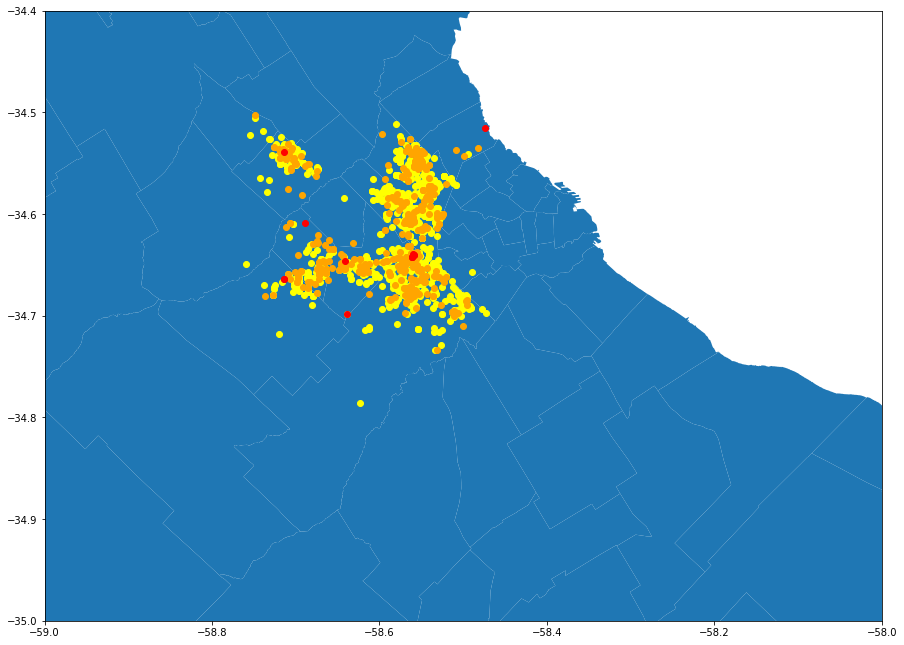

In [93]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
EPANOgdfpreciosbajos.to_crs("EPSG:4326").plot(ax=ax,color='yellow')
EPANOgdfpreciosmedios.to_crs("EPSG:4326").plot(ax=ax,color='orange')
EPANOgdfpreciosaltos.to_crs("EPSG:4326").plot(ax=ax,color='red')
ax.set_xlim(-59, -58)
ax.set_ylim(-35, -34.4)

(-34.8, -34.4)

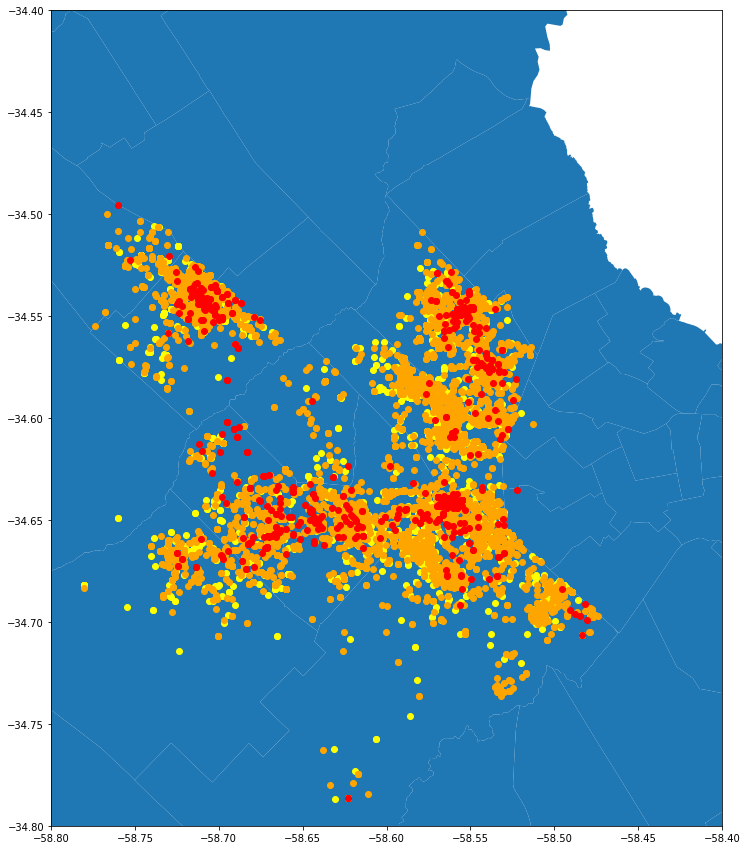

In [94]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
EPASIgdfpreciosbajos.to_crs("EPSG:4326").plot(ax=ax,color='yellow')
EPASIgdfpreciosmedios.to_crs("EPSG:4326").plot(ax=ax,color='orange')
EPASIgdfpreciosaltos.to_crs("EPSG:4326").plot(ax=ax,color='red')
ax.set_xlim(-58.8, -58.4)
ax.set_ylim(-34.8, -34.4)

Hago dummis del tipo de propiedad

In [95]:
gdf['type.1'].describe()

count            14049
unique               7
top       Departamento
freq             10696
Name: type.1, dtype: object

In [96]:
gdf.groupby(by='type.1').describe()

X                               ... Tercer_anillo           
                   count           mean           std  ...           50%   75%  max
type.1                                                 ...                         
Casa              1132.0  161833.287102  92991.604807  ...           0.0  0.00  1.0
Departamento     10696.0  163036.158938  92496.990914  ...           0.0  1.00  1.0
Local comercial    173.0  182189.427746  95619.360632  ...           0.0  1.00  1.0
Lote                 2.0  269633.500000  32441.352014  ...           0.5  0.75  1.0
Oficina            172.0  156305.866279  90179.812240  ...           0.0  0.00  1.0
Otro                 8.0  135691.750000  77242.644961  ...           0.0  0.25  1.0
PH                1866.0  159456.459807  93157.807250  ...           0.0  0.00  1.0

[7 rows x 160 columns]

In [97]:
gdf.groupby(by='type.1').count()

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l3,l4,l5,l6,geometry,distanciaPAL,precioxm2,logprice,logprecioxm2,InicioEPA,Ruido,Primer_anillo,Segundo_anillo,Tercer_anillo
type.1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Casa,1132,1132,1132,1132,1132,1132,1132,1132,1132,0,1132,1132,1132,1132,410,1132,1132,1132,1132,1132,879,1132,1132,1132,1132,1132,1132,1132,848,0,0,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132
Departamento,10696,10696,10696,10696,10696,10696,10696,10696,10696,0,10696,10696,10696,10696,6670,10696,10696,10696,10696,10696,8747,10696,10696,10696,10696,10696,10696,10696,8794,0,0,10696,10696,10696,10696,10696,10696,10696,10696,10696,10696
Local comercial,173,173,173,173,173,173,173,173,173,0,173,173,173,173,9,173,173,173,173,173,153,173,173,173,173,173,173,173,99,0,0,173,173,173,173,173,173,173,173,173,173
Lote,2,2,2,2,2,2,2,2,2,0,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,0,2,2,2,2,2,2,2,2,2,2
Oficina,172,172,172,172,172,172,172,172,172,0,172,172,172,172,98,172,172,172,172,172,155,172,172,172,172,172,172,172,151,0,0,172,172,172,172,172,172,172,172,172,172
Otro,8,8,8,8,8,8,8,8,8,0,8,8,8,8,1,8,8,8,8,8,8,8,8,8,8,8,8,8,3,0,0,8,8,8,8,8,8,8,8,8,8
PH,1866,1866,1866,1866,1866,1866,1866,1866,1866,0,1866,1866,1866,1866,1335,1866,1866,1866,1866,1866,1600,1866,1866,1866,1866,1866,1866,1866,1465,0,0,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866


In [98]:
dummitipo=pd.get_dummies(gdf['type.1'], prefix='dum')
dummitipo
gdf=pd.concat([gdf, dummitipo],axis=1)


Descripción de variables generales


In [99]:
gdf.describe()

,X,development,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,lat,lon,l6,distanciaPAL,precioxm2,logprice,logprecioxm2,InicioEPA,Ruido,Primer_anillo,Segundo_anillo,Tercer_anillo,dum_Casa,dum_Departamento,dum_Local comercial,dum_Lote,dum_Oficina,dum_Otro,dum_PH
count,14049.000000,0.0,14049.000000,8524.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,0.0,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000,14049.000000
mean,162616.839063,NaN,2.085202,1.277452,1.070539,51.770517,48.144138,9365.449427,-34.609146,-58.604481,NaN,7910.008204,190.251298,9.051916,5.170698,0.764610,0.006406,0.276247,0.476546,0.247206,0.080575,0.761335,0.012314,0.000142,0.012243,0.000569,0.132821
std,92653.582214,NaN,0.787729,0.661794,0.265077,19.537677,41.406577,4536.922592,0.051359,0.067909,NaN,3040.544565,86.756332,0.423356,0.394095,0.424258,0.079784,0.447157,0.499467,0.431403,0.272191,0.426283,0.110287,0.011931,0.109972,0.023857,0.339393
min,5.000000,NaN,1.000000,0.000000,1.000000,10.000000,1.000000,2000.000000,-34.786966,-58.780758,NaN,1329.669820,31.250000,7.600902,3.442019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,83598.000000,NaN,2.000000,1.000000,1.000000,38.000000,36.000000,6500.000000,-34.653366,-58.670254,NaN,5350.837163,138.297872,8.779557,4.929410,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,162733.000000,NaN,2.000000,1.000000,1.000000,46.000000,44.000000,8500.000000,-34.606763,-58.572276,NaN,7621.211925,181.818182,9.047821,5.203007,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,242145.000000,NaN,3.000000,2.000000,1.000000,60.000000,55.000000,11000.000000,-34.555196,-58.553635,NaN,9961.651361,227.272727,9.305651,5.426151,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,329147.000000,NaN,10.000000,6.000000,4.000000,119.000000,4473.000000,79000.000000,-34.495692,-58.472744,NaN,19672.110413,3260.869565,11.277203,8.089749,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Separo las aminities que están en detalle

In [100]:
#@title
gdf['dummycochera']=gdf.description.apply(lambda x:1 if 'Cochera' in x else 0)

In [101]:
#@title
gdf['dummycochera1']=gdf.description.apply(lambda x:1 if 'cochera' in x else 0)

In [102]:
#@title
gdf['dummygarage']=gdf.description.apply(lambda x:1 if 'Garage' in x else 0)

In [103]:
#@title
gdf['dummygarage1']=gdf.description.apply(lambda x:1 if 'garage' in x else 0)

In [104]:
#@title
gdf['dummyterraza']=gdf.description.apply(lambda x:1 if 'Terraza' in x else 0)

In [105]:
#@title
gdf['dummyterraza1']=gdf.description.apply(lambda x:1 if 'terraza' in x else 0)

In [106]:
#@title
gdf['dummypatio']=gdf.description.apply(lambda x:1 if 'Patio' in x else 0)

In [107]:
#@title
gdf['dummypatio1']=gdf.description.apply(lambda x:1 if 'patio' in x else 0)

In [108]:
#@title
gdf['dummybalcon']=gdf.description.apply(lambda x:1 if 'Balcon' in x else 0)

In [109]:
#@title
gdf['dummybalcon1']=gdf.description.apply(lambda x:1 if 'balcon' in x else 0)

In [110]:
#@title
gdf['dummybalcon2']=gdf.description.apply(lambda x:1 if 'Balcón' in x else 0)

In [111]:
#@title
gdf['dummybalcon3']=gdf.description.apply(lambda x:1 if 'balcón' in x else 0)

In [112]:
#@title
gdf['dummyjardin']=gdf.description.apply(lambda x:1 if 'Jardin' in x else 0)

In [113]:
#@title
gdf['dummyjardin1']=gdf.description.apply(lambda x:1 if 'jardin' in x else 0)

In [114]:
#@title
gdf['dummyjardin2']=gdf.description.apply(lambda x:1 if 'Jardín' in x else 0)

In [115]:
#@title
gdf['dummyjardin3']=gdf.description.apply(lambda x:1 if 'jardín' in x else 0)

In [116]:
#@title
gdf['dummypileta']=gdf.description.apply(lambda x:1 if 'Pileta' in x else 0)

In [117]:
#@title
gdf['dummypileta1']=gdf.description.apply(lambda x:1 if 'pileta' in x else 0)

In [118]:
#@title
gdf['dummyquincho']=gdf.description.apply(lambda x:1 if 'Quincho' in x else 0)

In [119]:
#@title
gdf['dummyquincho1']=gdf.description.apply(lambda x:1 if 'quincho' in x else 0)

In [120]:
#@title
gdf['dummylaundry']=gdf.description.apply(lambda x:1 if 'Laundry' in x else 0)

In [121]:
#@title
gdf['dummylaundry1']=gdf.description.apply(lambda x:1 if 'laundry' in x else 0)

In [122]:
#@title
gdf['dummybodega']=gdf.description.apply(lambda x:1 if 'Bodega' in x else 0)

In [123]:
#@title
gdf['dummybodega1']=gdf.description.apply(lambda x:1 if 'bodega' in x else 0)

In [124]:
#@title
gdf['dummyparrilla']=gdf.description.apply(lambda x:1 if 'Parrilla' in x else 0)

In [125]:
#@title
gdf['dummyparrilla1']=gdf.description.apply(lambda x:1 if 'parrilla' in x else 0)

In [126]:
#@title
gdf['dummyc_cochera']=gdf.description.apply(lambda x:1 if 'C/Cochera' in x else 0)

In [127]:
#@title
gdf['dummyseguridad']=gdf.description.apply(lambda x:1 if 'Seguridad' in x else 0)

In [128]:
#@title
gdf['dummyseguridad1']=gdf.description.apply(lambda x:1 if 'seguridad' in x else 0)

In [129]:
#@title
gdf['dummycalefaccioncentral']=gdf.description.apply(lambda x:1 if 'Calefaccion central' in x else 0)

In [130]:
#@title
gdf['dummycalefaccioncentral1']=gdf.description.apply(lambda x:1 if 'calefaccion central' in x else 0)

In [131]:
#@title
gdf['dummyserviciosind']=gdf.description.apply(lambda x:1 if 'Servicios individuales' in x else 0)

In [132]:
#@title
gdf['dummyserviciosinde']=gdf.description.apply(lambda x:1 if 'Servicios independientes' in x else 0)

In [133]:
#@title
gdf['dummylavadero']=gdf.description.apply(lambda x:1 if 'Lavadero' in x else 0)

In [134]:
#@title
gdf['dummylavadero1']=gdf.description.apply(lambda x:1 if 'lavadero' in x else 0)

In [135]:
#@title
gdf['dummysum']=gdf.description.apply(lambda x:1 if 'Sum' in x else 0)

In [136]:
#@title
gdf['dummyzoom']=gdf.description.apply(lambda x:1 if 'Zoom' in x else 0)

In [137]:
#@title
gdf['dummyascensor']=gdf.description.apply(lambda x:1 if 'Ascensor' in x else 0)

In [138]:
#@title
gdf['dummyascensor1']=gdf.description.apply(lambda x:1 if 'ascensor' in x else 0)

In [139]:
#@title
gdf['dummyventanas']=gdf.description.apply(lambda x:1 if 'Ventana' in x else 0)

In [140]:
#@title
gdf['dummyventanas1']=gdf.description.apply(lambda x:1 if 'ventana' in x else 0)

In [141]:
#@title
gdf['dummycerramiento']=gdf.description.apply(lambda x:1 if 'Cerramientos' in x else 0)

In [142]:
#@title
gdf['dummypenthouse']=gdf.description.apply(lambda x:1 if 'Pen house' in x else 0)

In [143]:
#@title
gdf['dummyhall']=gdf.description.apply(lambda x:1 if 'Hall' in x else 0)

In [144]:
#@title
gdf['dummyhall1']=gdf.description.apply(lambda x:1 if 'Halls' in x else 0)

In [145]:
#@title
gdf['dummyaeropuerto']=gdf.description.apply(lambda x:1 if 'Aeropuerto' in x else 0)

In [146]:
#@title
gdf['dummyaeropuerto1']=gdf.description.apply(lambda x:1 if 'aeropuerto' in x else 0)

In [147]:
#@title
gdf['dummypallier']=gdf.description.apply(lambda x:1 if 'pallier' in x else 0)

In [148]:
#@title
gdf['dummypalomar']=gdf.description.apply(lambda x:1 if 'Palomar' in x else 0)

In [149]:
#@title
gdf['dummypalomar1']=gdf.description.apply(lambda x:1 if 'palomar' in x else 0)

In [150]:
#@title
gdf['dummysolarium']=gdf.description.apply(lambda x:1 if 'Solarium' in x else 0)

In [151]:
#@title
gdf['dummysolarium1']=gdf.description.apply(lambda x:1 if 'solarium' in x else 0)

In [152]:
#@title
gdf['dummyruido']=gdf.description.apply(lambda x:1 if 'ruido' in x else 0)

Armo las dummi de amenities agrupadas

In [153]:
#@title
##gdf['amenitiescasa_ph']=np.where((gdf['dummmycochera'] = 1) & (gdf['dummmycochera1'] = 1) & (gdf['dummmygarage'] = 1) & (gdf['dummmygarage1'] = 1) & (gdf['dummmyterraza'] = 1) & (gdf['dummmyterraza1'] = 1) & (gdf['dummmypatio'] = 1) & (gdf['dummmypatio1'] = 1) & (gdf['dummmyjardin'] = 1) & (gdf['dummmyjardin1'] = 1) & (gdf['dummmyjardin2'] = 1) & (gdf['dummmyjardin3'] = 1) & (gdf['dummmypileta'] = 1) & (gdf['dummmypileta1'] = 1) & (gdf['dummmyquincho'] = 1) & (gdf['dummmyquincho1'] = 1) & (gdf['dummmyparrilla'] = 1) & (gdf['dummmyparrilla1'] = 1) & (gdf['dummmyventana'] = 1) & (gdf['dummmyventana1'] = 1) ,1,0)

In [154]:
#@title
##gdf['amenitiescasa_ph']=gdf[(gdf['dummmycochera'] == '1') & (gdf['dummmycochera1'] == '1'),1,0]

In [155]:
#@title
##gdf['amenitiesdepto']=np.where((gdf.dummmycochera = 1) & (gdf.dummmycochera1 = 1) & (gdf.dummmygarage = 1) & (gdf.dummmygarage1 = 1) & (gdf.dummmyterraza = 1) & (gdf.dummmyterraza1 = 1) & (gdf.dummmypileta = 1) & (gdf.dummmypileta1 = 1) & (gdf.dummmyparrilla = 1) & (gdf.dummmyparrilla1 = 1) & (gdf.dummmyventana = 1) & (gdf.dummmyventana1 = 1) & (gdf.dummmysolarium = 1) & (gdf.dummmysolarium1 = 1) & (gdf.dummmylavadero = 1) & (gdf.dummmylavadero1 = 1) & (gdf.dummmycalefaccioncentral = 1) & (gdf.dummmycalefaccioncentral1 = 1) & (gdf.dummmyseguridad = 1) & (gdf.dummmyseguridad1 = 1) & (gdf.dummmylaundry = 1) & (gdf.dummmylaundry1 = 1) & (gdf.dummmybalcon = 1) & (gdf.dummmybalcon1 = 1) & (gdf.dummmybalcon2 = 1) & (gdf.dummmybalcon3 = 1)

Armar las dummi de las localidades

In [156]:
dummilocalidades=pd.get_dummies(gdf['l3'], prefix='dum')
gdf=pd.concat([gdf, dummilocalidades],axis=1)



Armar modelos para describir el gradiente y las relaciones con los amenities o features

In [157]:
Y=gdf.price
X=gdf.distanciaPAL
X=sm.add_constant(X)

In [158]:
modelo=sm.OLS(Y,X)
resultados=modelo.fit()


In [159]:
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     24.76
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           6.57e-07
Time:                        16:20:31   Log-Likelihood:            -1.3821e+05
No. Observations:               14049   AIC:                         2.764e+05
Df Residuals:                   14047   BIC:                         2.764e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8870.3426    106.595     83.216   

Establecer una regla para la relación con la distancia del aeropuerto. (Preguntar a Ricardo)

Genero los GDF por cada anillo

In [160]:
#Primer anillo <5500
#Segundo anillo < 10000
#Tercer anillo < 20000

In [161]:
gdf.start_date.unique()

array(['2018-01-23', '2017-11-05', '2016-06-20', ..., '2020-02-25',
       '2017-11-01', '2020-03-25'], dtype=object)

In [162]:
#Outlierdistancia=gdf['distanciaPAL']<20000

In [163]:
#GBAl3=GBAl3.loc[mask]

In [164]:
#PRIMER ANILLO GENERAL

In [165]:
primeranillo=gdf['distanciaPAL']<5500

In [166]:
gdfprimeranillo=gdf.loc[primeranillo]

In [167]:
gdfprimeranillo.start_date.unique()

array(['2019-12-12', '2018-04-06', '2016-05-15', ..., '2019-07-31',
       '2019-01-22', '2017-07-19'], dtype=object)

In [168]:
#SEGUNDO ANILLO GENERAL

In [169]:
segundoanillo=(gdf['distanciaPAL'] >= 5500) & (gdf['distanciaPAL'] < 10000)

In [170]:
gdfsegundoanillo=gdf.loc[segundoanillo]

In [171]:
gdfsegundoanillo.precioxm2.describe()

count    6695.000000
mean      188.177466
std        85.708248
min        31.818182
25%       132.305503
50%       178.571429
75%       228.571429
max      2000.000000
Name: precioxm2, dtype: float64

In [172]:
#TERCER ANILLO GENERAL

In [173]:
terceranillo=(gdf['distanciaPAL'] >= 10000) & (gdf['distanciaPAL'] < 20000)

In [174]:
gdfterceranillo=gdf.loc[terceranillo]

In [175]:
gdfterceranillo.precioxm2.describe()

count    3473.000000
mean      197.786037
std        82.088062
min        31.250000
25%       155.172414
50%       190.000000
75%       230.769231
max      1764.705882
Name: precioxm2, dtype: float64

In [176]:
gdfterceranillo.l3.unique()

array(['General San Martín', 'San Miguel', 'José C Paz', 'La Matanza',
       'Merlo', 'Tres de Febrero', 'Morón', 'Ituzaingó'], dtype=object)

Ahora voy a poner cada anillo en EPASI EPANO

In [177]:
EPASImask=gdfprimeranillo['InicioEPA']==1

In [178]:
EPASIprimeranillo = gdfprimeranillo[EPASImask]

In [179]:
EPANOmask=gdfprimeranillo['InicioEPA']==0

In [180]:
EPANOprimeranillo = gdfprimeranillo[EPANOmask]

In [181]:
EPANOprimeranillo.groupby(by='type.1').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
type.1,,,,,,,,
Casa,46.0,109.571826,40.838278,50.000000,80.000000,100.000000,127.678571,263.157895
Departamento,906.0,124.315923,41.783034,40.434783,101.184117,122.222222,140.625000,716.666667
Local comercial,3.0,350.399419,215.929127,166.666667,231.481481,296.296296,442.265795,588.235294
Oficina,12.0,168.856383,36.369588,107.142857,146.657754,161.458333,200.000000,225.000000
PH,71.0,96.890494,36.969710,37.500000,67.226891,90.000000,116.709184,200.000000


In [182]:
print(EPANOprimeranillo.groupby(by='l3').precioxm2.describe())

                    count        mean  ...         75%         max
l3                                     ...                        
General San Martín   37.0   96.966534  ...  111.111111  186.666667
Hurlingham            4.0  139.465726  ...  163.709677  200.000000
Ituzaingó             8.0  148.880034  ...  171.875000  296.296296
La Matanza           34.0  153.259916  ...  192.307692  260.000000
Morón               272.0  137.179372  ...  150.000000  716.666667
Tres de Febrero     683.0  116.789076  ...  135.450269  261.111111

[6 rows x 8 columns]


In [183]:
EPASIprimeranillo.precioxm2.describe()

count    2843.000000
mean      210.500957
std        93.744173
min        60.869565
25%       166.666667
50%       200.000000
75%       240.384615
max      3260.869565
Name: precioxm2, dtype: float64

In [184]:
EPANOprimeranillo.precioxm2.describe()

count    1038.000000
mean      122.954943
std        44.969936
min        37.500000
25%       100.000000
50%       120.000000
75%       140.625000
max       716.666667
Name: precioxm2, dtype: float64

In [185]:
EPANOprimeranillo.groupby(by='l3').precioxm2.mean()

l3
General San Martín     96.966534
Hurlingham            139.465726
Ituzaingó             148.880034
La Matanza            153.259916
Morón                 137.179372
Tres de Febrero       116.789076
Name: precioxm2, dtype: float64

In [186]:
EPASIprimeranillo.groupby(by='type.1').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
type.1,,,,,,,,
Casa,193.0,184.209668,80.202128,60.869565,133.333333,171.428571,216.494845,650.000000
Departamento,2355.0,214.207418,93.613613,77.777778,173.913043,204.545455,244.444444,3260.869565
Local comercial,15.0,423.317940,180.222183,257.142857,300.779727,358.333333,500.000000,944.444444
Oficina,22.0,284.276941,130.704197,120.833333,200.000000,257.142857,328.660714,642.857143
PH,258.0,177.672180,64.061462,73.913043,135.785714,166.666667,209.919355,681.818182


(-34.8, -34.4)

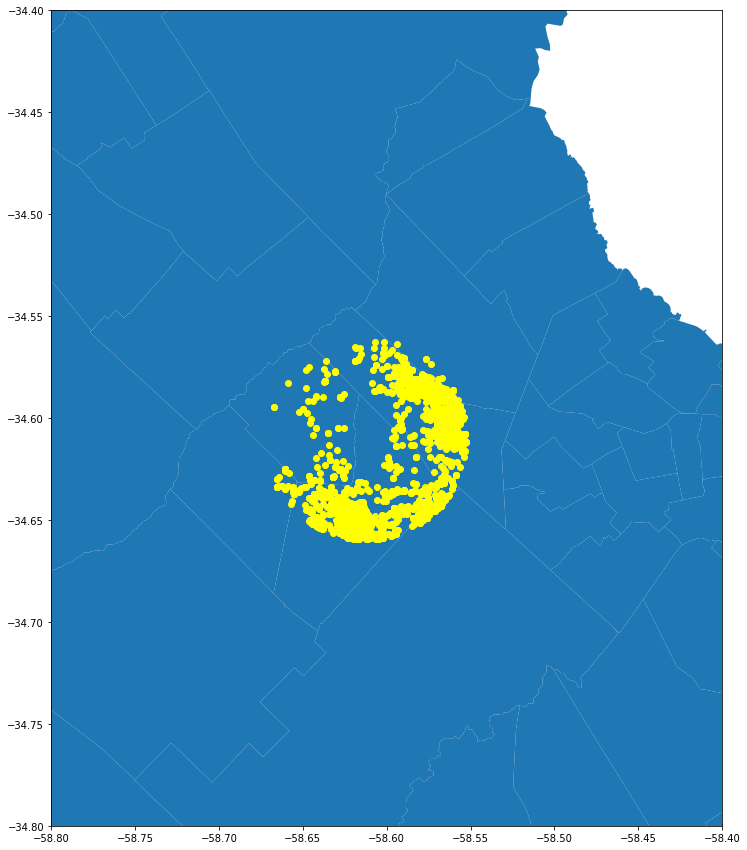

In [187]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
EPASIprimeranillo.to_crs("EPSG:4326").plot(ax=ax,color='yellow')
ax.set_xlim(-58.8, -58.4)
ax.set_ylim(-34.8, -34.4)

(-34.8, -34.4)

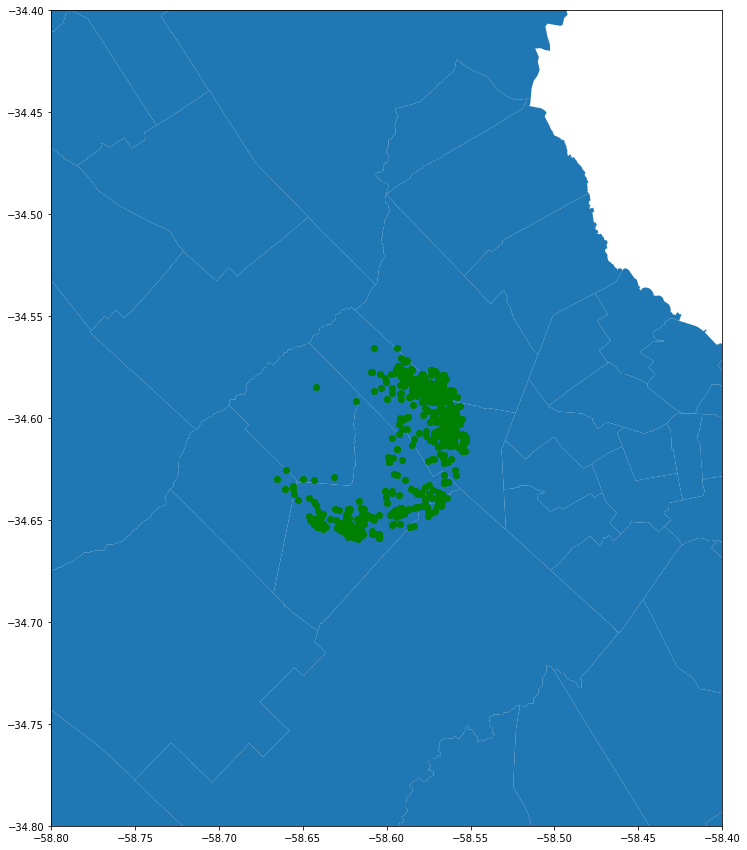

In [188]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
EPANOprimeranillo.to_crs("EPSG:4326").plot(ax=ax,color='green')
ax.set_xlim(-58.8, -58.4)
ax.set_ylim(-34.8, -34.4)

In [189]:
#SEGUNDO ANILLO

In [190]:
EPASI2=gdfsegundoanillo['InicioEPA']==1

In [191]:
EPASIsegundoanillo = gdfsegundoanillo[EPASI2]

In [192]:
EPASIsegundoanillo.precioxm2.describe()

count    4865.000000
mean      213.976484
std        83.772303
min        39.090909
25%       166.666667
50%       200.000000
75%       250.000000
max      2000.000000
Name: precioxm2, dtype: float64

In [193]:
EPANO2=gdfsegundoanillo['InicioEPA']==0

In [194]:
EPANOsegundoanillo = gdfsegundoanillo[EPANO2]

In [195]:
EPASIsegundoanillo.precioxm2.describe()

count    4865.000000
mean      213.976484
std        83.772303
min        39.090909
25%       166.666667
50%       200.000000
75%       250.000000
max      2000.000000
Name: precioxm2, dtype: float64

In [196]:
EPASIsegundoanillo.groupby(by='type.1').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
type.1,,,,,,,,
Casa,511.0,181.117601,55.741367,39.090909,142.261905,175.714286,211.805556,555.555556
Departamento,3354.0,218.229065,66.942707,75.000000,172.727273,209.090909,250.000000,900.000000
Local comercial,74.0,345.307093,149.203894,157.142857,250.000000,314.980159,371.829710,888.888889
Lote,1.0,300.000000,NaN,300.000000,300.000000,300.000000,300.000000,300.000000
Oficina,76.0,318.731303,154.734254,111.111111,208.246753,277.096774,408.333333,1041.666667
Otro,6.0,140.357143,62.782017,75.000000,98.214286,132.142857,157.500000,250.000000
PH,843.0,196.424402,114.616004,47.413793,147.368421,181.250000,225.000000,2000.000000


In [197]:
EPASIsegundoanillo.groupby(by='l3').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
l3,,,,,,,,
General San Martín,1691.0,213.270278,80.573247,70.000000,166.666667,200.000000,250.000000,1454.545455
Hurlingham,1.0,266.666667,NaN,266.666667,266.666667,266.666667,266.666667,266.666667
Ituzaingó,665.0,214.834875,93.602986,57.777778,158.333333,200.000000,250.000000,1041.666667
La Matanza,1446.0,219.725207,78.326844,47.413793,169.295958,209.302326,250.000000,900.000000
Merlo,36.0,194.011716,83.683672,110.769231,135.000000,166.666667,222.222222,461.538462
Morón,311.0,198.789843,70.539302,76.923077,151.162791,190.000000,228.571429,800.000000
San Miguel,152.0,205.499460,56.230495,85.937500,170.441176,210.526316,228.720238,375.000000
Tres de Febrero,563.0,212.179518,103.878488,39.090909,170.333656,200.000000,236.842105,2000.000000


(-34.8, -34.4)

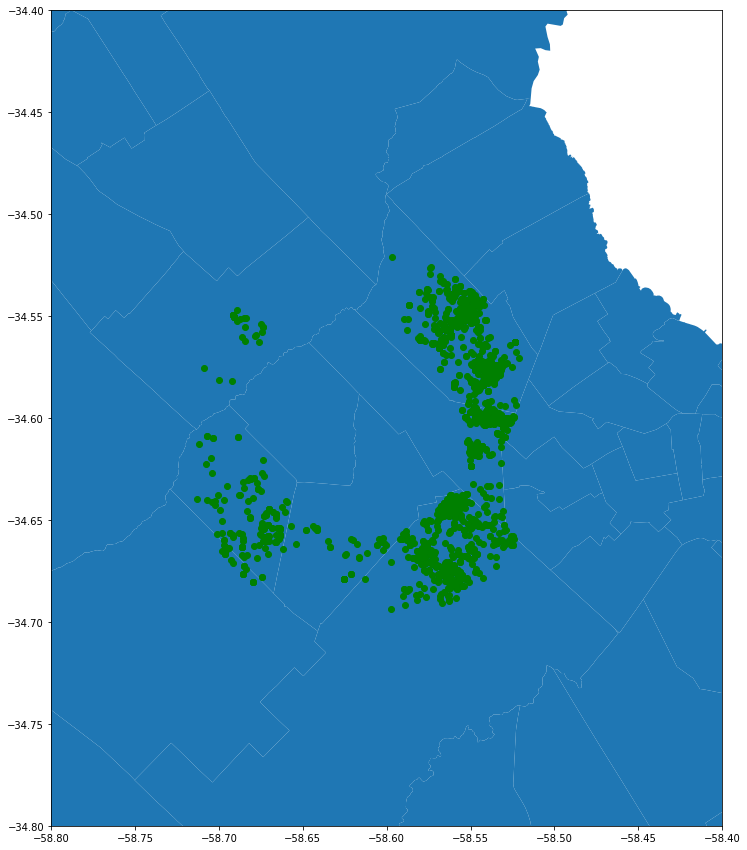

In [198]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
EPANOsegundoanillo.to_crs("EPSG:4326").plot(ax=ax,color='green')
ax.set_xlim(-58.8, -58.4)
ax.set_ylim(-34.8, -34.4)

(-34.8, -34.4)

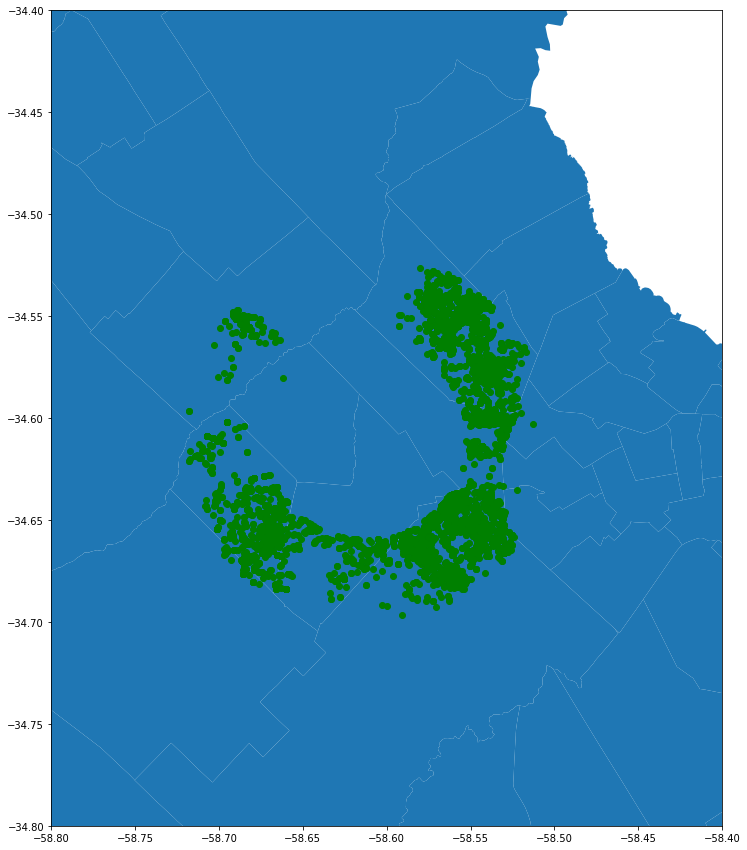

In [199]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
EPASIsegundoanillo.to_crs("EPSG:4326").plot(ax=ax,color='green')
ax.set_xlim(-58.8, -58.4)
ax.set_ylim(-34.8, -34.4)

In [200]:
#TERCER ANILLO

In [201]:
EPASI3=gdfterceranillo['InicioEPA']==1

In [202]:
EPASIterceranillo = gdfterceranillo[EPASI3]

In [203]:
EPASIterceranillo.precioxm2.describe()

count    3034.000000
mean      208.294634
std        81.410846
min        31.250000
25%       166.666667
50%       200.000000
75%       237.500000
max      1764.705882
Name: precioxm2, dtype: float64

In [204]:
EPANO3=gdfterceranillo['InicioEPA']==0

In [205]:
EPANOterceranillo = gdfterceranillo[EPANO3]

In [206]:
EPASIterceranillo.precioxm2.describe()

count    3034.000000
mean      208.294634
std        81.410846
min        31.250000
25%       166.666667
50%       200.000000
75%       237.500000
max      1764.705882
Name: precioxm2, dtype: float64

In [207]:
EPASIterceranillo.groupby(by='type.1').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
type.1,,,,,,,,
Casa,240.0,188.128513,66.299211,76.190476,140.000000,178.888889,222.916667,500.000000
Departamento,2382.0,210.574655,77.398825,31.250000,174.286469,200.000000,238.501082,1764.705882
Local comercial,61.0,360.791274,167.886596,133.333333,250.000000,321.428571,394.736842,909.090909
Lote,1.0,297.297297,NaN,297.297297,297.297297,297.297297,297.297297,297.297297
Oficina,28.0,260.562651,78.604046,108.333333,200.000000,247.222222,325.268817,400.000000
Otro,2.0,166.899586,83.849981,107.608696,137.254141,166.899586,196.545031,226.190476
PH,320.0,172.784778,53.200795,60.000000,133.333333,167.500000,200.000000,341.428571


In [208]:
EPASIterceranillo.groupby(by='l3').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
l3,,,,,,,,
General San Martín,50.0,170.558519,59.873566,69.565217,127.232143,169.615385,191.451613,339.285714
Ituzaingó,3.0,160.000000,0.000000,160.000000,160.000000,160.000000,160.000000,160.000000
José C Paz,147.0,196.744257,53.860674,86.956522,155.363985,200.000000,226.785714,380.000000
La Matanza,499.0,191.617434,68.872099,58.585859,150.000000,180.851064,218.750000,1000.000000
Merlo,432.0,208.334890,82.070490,31.250000,150.000000,197.142857,250.000000,789.473684
Morón,4.0,154.166667,34.013886,106.666667,146.666667,161.250000,168.750000,187.500000
San Miguel,1899.0,214.745734,85.597914,60.000000,175.974026,202.380952,240.000000,1764.705882


Serie de tiempo de anillos previo al EPA para asumir tendencias paralelas

In [209]:
# Set the Date as Index

#EPANOfechas = pd.DataFrame(EPANOprimeranillo, columns = ['start_date', 'precioxm2'])
#EPANOfechas['start_date'] = pd.to_datetime(EPANOfechas['start_date'])
#EPANOfechas.index = EPANOfechas['start_date']
#del EPANOfechas['start_date']
#EPANOfechas['Mes'] = EPANOfechas.index.month                               
#EPANOfechas['Año'] = EPANOfechas.index.year
#EPANOfechas['day'] = EPANOfechas.index.day

#EPANOfechas.plot(figsize=(10, 6))
#plt.show()


In [210]:
#EPANOfechasmes.head()

In [211]:
#EPANOfechas['Mes'] = pd.to_datetime(EPANOfechas['Mes'])
#EPANOfechas.index = EPANOfechas['Mes']
#del EPANOfechas['Mes']

#EPANOfechasmes = pd.DataFrame(EPANOfechas, columns = ['Mes', 'precioxm2'])
#EPANOfechasmes.Mes.plot(figsize=(10, 6))
#plt.show()

PRIMER ANILLO FECHAS

In [212]:
import pandas as pd
EPANOprimeranillo['monthyear']=pd.to_datetime(EPANOprimeranillo.start_date).dt.to_period('M')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


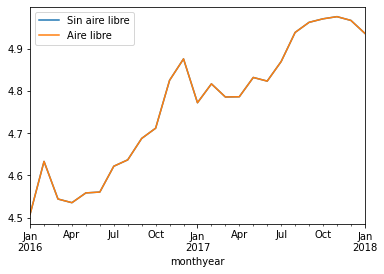

In [213]:
EPANOprimeranillo_months=EPANOprimeranillo.groupby(by=['monthyear']).logprecioxm2.mean().rename('media').reset_index()
ax=EPANOprimeranillo_months.plot(x='monthyear',y='media', label='Sin aire libre')
EPANOprimeranillo_months.plot(x='monthyear',y='media', ax=ax, label='Aire libre')

#TERCER ANILLO FECHAS

In [214]:
import pandas as pd
EPANOterceranillo['monthyear']=pd.to_datetime(EPANOterceranillo.start_date).dt.to_period('M')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


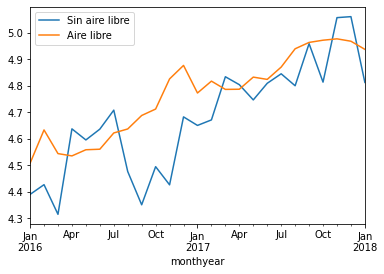

In [215]:
EPANOterceranillo_months=EPANOterceranillo.groupby(by=['monthyear']).logprecioxm2.mean().rename('media').reset_index()
ax=EPANOterceranillo_months.plot(x='monthyear',y='media', label='Sin aire libre')
EPANOprimeranillo_months.plot(x='monthyear',y='media', ax=ax, label='Aire libre')

In [216]:
EPANOprimeranillo['quarteryear']=pd.to_datetime(EPANOprimeranillo.start_date).dt.to_period('Q')
EPANOprimeranillo_quarters=EPANOprimeranillo.groupby(by=['quarteryear']).logprecioxm2.mean().rename('media').reset_index()


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [217]:
EPANOterceranillo['quarteryear']=pd.to_datetime(EPANOterceranillo.start_date).dt.to_period('Q')
EPANOterceranillo_quarters=EPANOterceranillo.groupby(by=['quarteryear']).logprecioxm2.mean().rename('media').reset_index()


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


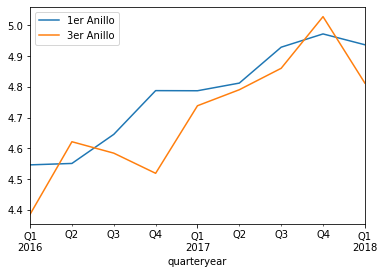

In [218]:
ax=EPANOprimeranillo_quarters.plot(x='quarteryear',y='media', label='1er Anillo')
EPANOterceranillo_quarters.plot(x='quarteryear',y='media', ax=ax, label='3er Anillo')

In [219]:
EPASIprimeranillo['quarteryear']=pd.to_datetime(EPASIprimeranillo.start_date).dt.to_period('Q')
EPASIprimeranillo_quarters=EPASIprimeranillo.groupby(by=['quarteryear']).logprecioxm2.mean().rename('media').reset_index()


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [220]:
EPASIterceranillo['quarteryear']=pd.to_datetime(EPASIterceranillo.start_date).dt.to_period('Q')
EPASIterceranillo_quarters=EPASIterceranillo.groupby(by=['quarteryear']).logprecioxm2.mean().rename('media').reset_index()


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


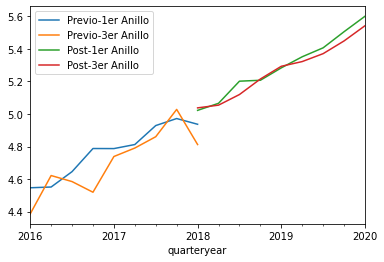

In [221]:
ax=EPANOprimeranillo_quarters.plot(x='quarteryear',y='media', label='Previo-1er Anillo')
EPANOterceranillo_quarters.plot(x='quarteryear',y='media', ax=ax, label='Previo-3er Anillo')
EPASIprimeranillo_quarters.plot(x='quarteryear',y='media', ax=ax, label='Post-1er Anillo')
EPASIterceranillo_quarters.plot(x='quarteryear',y='media', ax=ax, label='Post-3er Anillo')

In [222]:
gdfterceranillo['quarteryear']=pd.to_datetime(gdfterceranillo.start_date).dt.to_period('Q')
gdfterceranillo_quarters=gdfterceranillo.groupby(by=['quarteryear']).logprecioxm2.mean().rename('media').reset_index()
gdfprimeranillo['quarteryear']=pd.to_datetime(gdfprimeranillo.start_date).dt.to_period('Q')
gdfprimeranillo_quarters=gdfprimeranillo.groupby(by=['quarteryear']).logprecioxm2.mean().rename('media').reset_index()
gdfsegundoanillo['quarteryear']=pd.to_datetime(gdfsegundoanillo.start_date).dt.to_period('Q')
gdfsegundoanillo_quarters=gdfsegundoanillo.groupby(by=['quarteryear']).logprecioxm2.mean().rename('media').reset_index()


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


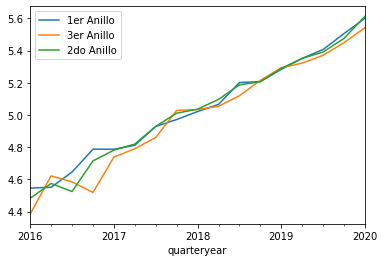

In [223]:
ax=gdfprimeranillo_quarters.plot(x='quarteryear',y='media', label='1er Anillo')
gdfterceranillo_quarters.plot(x='quarteryear',y='media', ax=ax, label='3er Anillo')
gdfsegundoanillo_quarters.plot(x='quarteryear',y='media', ax=ax, label='2do Anillo')


In [224]:
gdfterceranillo.groupby(by='type.1').rooms.describe()
print(EPANOprimeranillo.groupby(by='l3').precioxm2.describe())

                    count        mean  ...         75%         max
l3                                     ...                        
General San Martín   37.0   96.966534  ...  111.111111  186.666667
Hurlingham            4.0  139.465726  ...  163.709677  200.000000
Ituzaingó             8.0  148.880034  ...  171.875000  296.296296
La Matanza           34.0  153.259916  ...  192.307692  260.000000
Morón               272.0  137.179372  ...  150.000000  716.666667
Tres de Febrero     683.0  116.789076  ...  135.450269  261.111111

[6 rows x 8 columns]


In [225]:
gdf

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l3,l4,l5,l6,geometry,distanciaPAL,precioxm2,logprice,logprecioxm2,InicioEPA,Ruido,Primer_anillo,...,dummybodega,dummybodega1,dummyparrilla,dummyparrilla1,dummyc_cochera,dummyseguridad,dummyseguridad1,dummycalefaccioncentral,dummycalefaccioncentral1,dummyserviciosind,dummyserviciosinde,dummylavadero,dummylavadero1,dummysum,dummyzoom,dummyascensor,dummyascensor1,dummyventanas,dummyventanas1,dummycerramiento,dummypenthouse,dummyhall,dummyhall1,dummyaeropuerto,dummyaeropuerto1,dummypallier,dummypalomar,dummypalomar1,dummysolarium,dummysolarium1,dummyruido,dum_General San Martín,dum_Hurlingham,dum_Ituzaingó,dum_José C Paz,dum_La Matanza,dum_Merlo,dum_Morón,dum_San Miguel,dum_Tres de Febrero
2,5,Propiedad,Propiedad,Argentina,b'\x07\x11\xf3\xb8~\xdb\x0f \xfc\x0f>>\x18\xd7...,2018-01-23,2018-03-01,2018-01-23,"{'lat': -34.5495042, 'lon': -58.6856867, 'l1':...",NaN,Alquiler,Alquiler,Casa,Casa,3.0,2.0,2.0,70,70,9500,ARS,Mensual,Dplex con dos dormitorios + altillo en alquiler,Dplex con dos dormitorios + altillo en alquile...,-34.549504,-58.685687,Argentina,Bs.As. G.B.A. Zona Norte,San Miguel,Bella Vista,NaN,NaN,POINT (79532.142 108875.822),9493.979199,135.714286,9.159047,4.910552,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
17,60,Propiedad,Propiedad,Argentina,b'%\xa1\xbcoq\x94Z\xca\x89\xad\xa4\xa5\xa3<\x9c2',2017-11-05,2018-03-25,2017-11-05,"{'lat': -34.517044, 'lon': -58.578155, 'l1': '...",NaN,Alquiler,Alquiler,PH,PH,1.0,1.0,1.0,31,31,3500,ARS,Mensual,Alquiler monoambiente Jose L Suarez,Corredor Responsable: Uno Bienes Raices SRL - ...,-34.517044,-58.578155,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Jose Leon Suarez,NaN,NaN,POINT (89398.327 112493.315),10783.064719,112.903226,8.160518,4.726531,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
33,119,Propiedad,Propiedad,Argentina,b'\x07\xf9\xbb*CD\x81\xa7dq\x1a\x00\x1elg\x97',2016-06-20,2016-07-28,2016-06-20,"{'lat': -34.5553622, 'lon': -58.5618564, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,2.0,1.0,1.0,50,40,6000,ARS,Mensual,Depto T/casa de 2 ambientes - 2 COCHERAS,DEPARTAMENTO TIPO CASA AL FRENTE<br>Living Com...,-34.555362,-58.561856,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (90899.119 108244.086),7637.476177,120.000000,8.699515,4.787492,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
34,120,Propiedad,Propiedad,Argentina,b'\xd8\x1a|\x11\xaed\xde\x8a&\n\xad-\xc2\x12\x...,2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,38,36,4000,ARS,Mensual,depto 2 amb,depto 2 amb. 2 piso al contrafrente<br>cuenta ...,-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,105.263158,8.294050,4.656463,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
35,121,Propiedad,Propiedad,Argentina,b'\xdd+\xaf\xa7\x96\xb8J\xfeI\xa8g}\xdfX\x84e',2016-06-20,2016-08-08,2016-06-20,"{'lat': -34.577168, 'lon': -58.538654, 'l1': '...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,47,42,4800,ARS,Mensual,depto 2 amb,"Depto al contrafrente, cuenta con cocina comed...",-34.577168,-58.538654,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (93030.527 105826.901),7691.734708,102.127660,8.476371,4.626224,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [226]:
#df['quarteryear']=pd.to_datetime(df.start_date).dt.to_period('Q')
#df_quarters=df.groupby(by=['quarteryear','airelibre']).logprice.mean().rename('media').reset_index()
#ax=df_quarters.loc[df_quarters.airelibre==0].plot(x='quarteryear',y='media', label='Sin aire libre')
#df_quarters.loc[df_quarters.airelibre==1].plot(x='quarteryear',y='media', ax=ax, label='Aire libre')

Mapeo los anillos

(-34.8, -34.4)

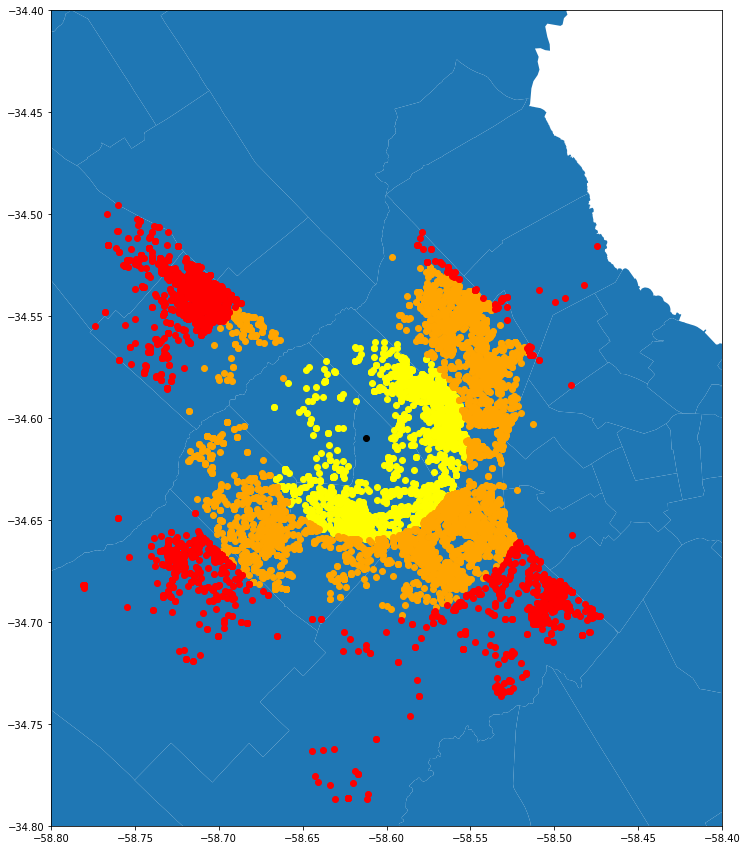

In [227]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
gdfprimeranillo.to_crs("EPSG:4326").plot(ax=ax,color='yellow')
gdfsegundoanillo.to_crs("EPSG:4326").plot(ax=ax,color='orange')
aeropuerto.to_crs("EPSG:4326").plot(ax=ax,color='black')
gdfterceranillo.to_crs("EPSG:4326").plot(ax=ax,color='red')
ax.set_xlim(-58.8, -58.4)
ax.set_ylim(-34.8, -34.4)

Crear variables de ruido en primer anillo de distancia

In [228]:
primeranilloruido1=gdf['distanciaPAL']<2500

In [229]:
gdfprimeranilloruido1=gdf.loc[primeranilloruido1]

In [230]:
primeranilloruido2=(gdf['distanciaPAL'] >= 2500) & (gdf['distanciaPAL'] < 4000)

In [231]:
gdfprimeranilloruido2=gdf.loc[primeranilloruido2]

(-34.67, -34.55)

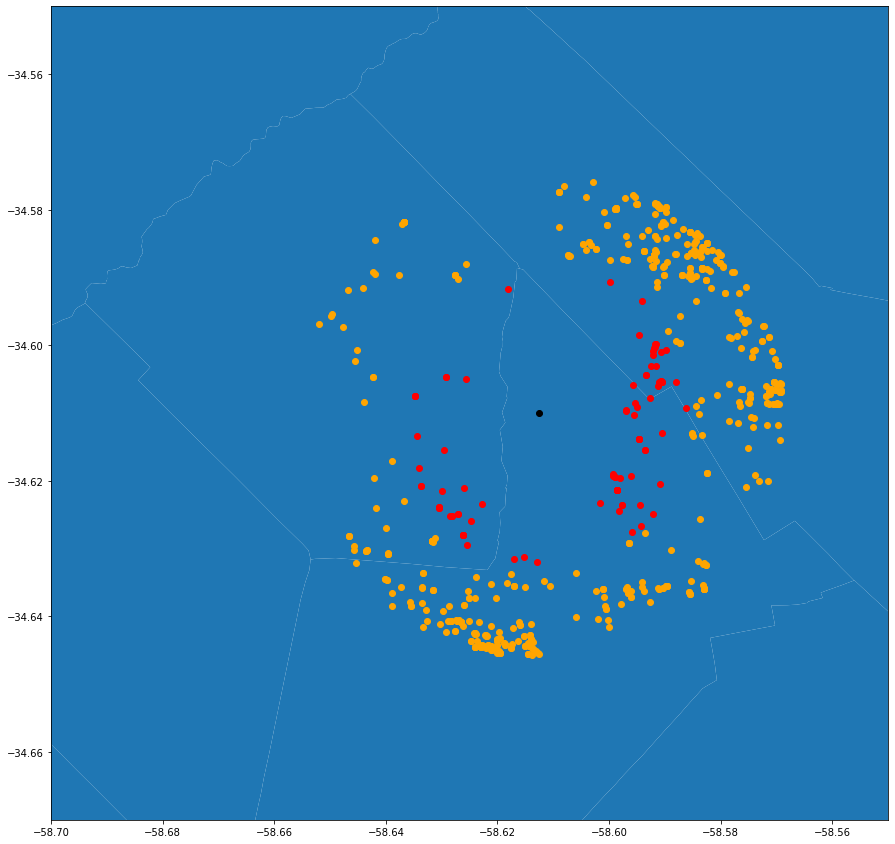

In [232]:
fig, ax = plt.subplots(figsize=(15, 15))
limites.to_crs("EPSG:4326").plot(ax=ax)
gdfprimeranilloruido1.to_crs("EPSG:4326").plot(ax=ax,color='red')
gdfprimeranilloruido2.to_crs("EPSG:4326").plot(ax=ax,color='orange')
aeropuerto.to_crs("EPSG:4326").plot(ax=ax,color='black')
ax.set_xlim(-58.7, -58.55)
ax.set_ylim(-34.67, -34.55)

In [233]:
EPASIprimeranillo.to_csv('data\\descargatest2020\\tratamiento.csv')


Codigo para descargar bases en CSV

In [234]:
#gdfprimeranillo.to_csv('data\\descargatest2020\\gdfprimeranillo.csv')
#Trat2018.to_csv('data\\descargatest2020\\tratamiento18.csv')

#################################################################################################################################################################################################################################################################################################################################################################################################################

In [235]:
#df['airelibre']=np.where((df.patio=='1')| (df.terraza=='1'),1,0)

¿Cuánto fue el alquiler promedio de un departamento tomando el año completo?


Exploramos la diferencia en diferencia \

$E[y|t=aire,Post]-E[y|t=aire,Pre]=\lambda_{POST}+\beta-\lambda_{PRE}$
$E[y|t=sinaire,Post]-E[y|t=sinaire,Pre]=\lambda_{POST}-\lambda_{PRE}$


In [236]:
#dif_InicioEPA=gdf.loc[(gdf.InicioEPA==1)&(gdf.distanciaPAL)].logprice.mean()-df.loc[(df.postcovid==0)&(df.airelibre==1)].price.mean()
#dif_InicioEPA

In [237]:
#dif_sin_airelibre=df.loc[(df.postcovid==1)&(df.airelibre==0)].price.mean()-df.loc[(df.postcovid==0)&(df.airelibre==0)].price.mean()
#dif_sin_airelibre

In [238]:
#dif_airelibre-dif_sin_airelibre

Misma cuenta en logs

In [239]:
#df['logprice']=np.log(df.price)
#df['logpricem2']=np.log(df.price/df.surface_to)

In [240]:
#dif_airelibre=df.loc[(df.postcovid==1)&(df.airelibre==1)].logprice.mean()-df.loc[(df.postcovid==0)&(df.airelibre==1)].logprice.mean()
#dif_sin_airelibre=df.loc[(df.postcovid==1)&(df.airelibre==0)].logprice.mean()-df.loc[(df.postcovid==0)&(df.airelibre==0)].logprice.mean()
#dif_airelibre-dif_sin_airelibre

#Modelos hedónicos de los anillos

In [241]:
def regress(lista, data):
  """ 
  Funcion que realiza la regresion OLS
  La primera variable de la lista es la dependiente, el resto son las explicativas
  data es la base de datos
  """
  datos=data[lista]
  # el metodo dropna() me permite eliminar las filas que tienen algun valor missing
  datos=datos.dropna()
  Y=datos[lista[0]]
  X=datos[lista[1:]]
  X=sm.add_constant(X)
  modelo=sm.OLS(Y,X)
  resultados=modelo.fit()
  print(resultados.summary())


In [242]:
#https://colab.research.google.com/github/rpasquini/urban-econometrics/blob/master/OLS4_Regresion_Multiple.ipynb#scrollTo=p7w8Z5g2faBg

EPANO primer anillo

In [243]:
hedonicosEPANOprimeranillo=EPANOprimeranillo[['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina','InicioEPA','Ruido']]
hedonicosEPANOprimeranillo=hedonicosEPANOprimeranillo.dropna()

In [244]:
regress(['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina'], hedonicosEPANOprimeranillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     26.95
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           8.22e-34
Time:                        16:21:16   Log-Likelihood:                -121.98
No. Observations:                 944   AIC:                             260.0
Df Residuals:                     936   BIC:                             298.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.6184    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


Primer anillo InicioEPA+Ruido

In [245]:
regress(['logprecioxm2', 'InicioEPA','Ruido'], gdfprimeranillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     1168.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:16   Log-Likelihood:                -916.20
No. Observations:                3881   AIC:                             1838.
Df Residuals:                    3878   BIC:                             1857.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7656      0.010    499.704      0.0

EPASI primer anillo

In [246]:
hedonicosEPASIprimeranillo=EPASIprimeranillo[['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina','InicioEPA','Ruido']]
hedonicosEPASIprimeranillo=hedonicosEPASIprimeranillo.dropna()

In [247]:
regress(['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina'], hedonicosEPASIprimeranillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     27.48
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           6.77e-36
Time:                        16:21:16   Log-Likelihood:                -303.21
No. Observations:                1645   AIC:                             622.4
Df Residuals:                    1637   BIC:                             665.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1824    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


EPANO segundo anillo

In [248]:
hedonicosEPANOsegundoanillo=EPANOsegundoanillo[['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina','InicioEPA','Ruido']]
hedonicosEPANOsegundoanillo=hedonicosEPANOsegundoanillo.dropna()

In [249]:
regress(['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina'], hedonicosEPANOsegundoanillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     29.49
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           3.14e-43
Time:                        16:21:16   Log-Likelihood:                -311.76
No. Observations:                1602   AIC:                             641.5
Df Residuals:                    1593   BIC:                             689.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1922    

In [250]:
regress(['logprecioxm2','InicioEPA','Ruido'], gdfsegundoanillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     4199.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:17   Log-Likelihood:                -2007.8
No. Observations:                6695   AIC:                             4020.
Df Residuals:                    6693   BIC:                             4033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7296      0.008    619.407      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


EPASI segundo anillo

In [251]:
hedonicosEPASIsegundoanillo=EPASIsegundoanillo[['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina','InicioEPA','Ruido']]
hedonicosEPASIsegundoanillo=hedonicosEPASIsegundoanillo.dropna()

In [252]:
regress(['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina'], EPASIsegundoanillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     31.59
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           1.15e-47
Time:                        16:21:17   Log-Likelihood:                -676.37
No. Observations:                2584   AIC:                             1371.
Df Residuals:                    2575   BIC:                             1423.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.6955    

EPANO tercer anillo

In [253]:
hedonicosEPANOterceranillo=EPANOterceranillo[['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina','InicioEPA','Ruido']]
hedonicosEPANOterceranillo=hedonicosEPANOterceranillo.dropna()

In [254]:
regress(['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina'], hedonicosEPANOterceranillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     19.61
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           2.48e-24
Time:                        16:21:17   Log-Likelihood:                -38.446
No. Observations:                 352   AIC:                             94.89
Df Residuals:                     343   BIC:                             129.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.9269    

In [255]:
regress(['logprecioxm2','InicioEPA','Ruido'], gdfterceranillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     1082.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):          7.64e-207
Time:                        16:21:17   Log-Likelihood:                -795.44
No. Observations:                3473   AIC:                             1595.
Df Residuals:                    3471   BIC:                             1607.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7793      0.015    329.031      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


EPASI tercer anillo

In [256]:
hedonicosEPASIterceranillo=EPASIterceranillo[['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina','InicioEPA','Ruido']]
hedonicosEPASIterceranillo=hedonicosEPASIterceranillo.dropna()

In [257]:
regress(['logprecioxm2','rooms','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina'], hedonicosEPASIterceranillo)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     15.51
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           2.40e-24
Time:                        16:21:17   Log-Likelihood:                -199.53
No. Observations:                1397   AIC:                             419.1
Df Residuals:                    1387   BIC:                             471.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.3079    

In [258]:
gdfprimeranillo.head()

,X,type,type_i18n,country,id,start_date,end_date,created_on,place,development,operation,operation_i18n,type.1,type_i18n.1,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,lat,lon,l1,l2,l3,l4,l5,l6,geometry,distanciaPAL,precioxm2,logprice,logprecioxm2,InicioEPA,Ruido,Primer_anillo,...,dummybodega1,dummyparrilla,dummyparrilla1,dummyc_cochera,dummyseguridad,dummyseguridad1,dummycalefaccioncentral,dummycalefaccioncentral1,dummyserviciosind,dummyserviciosinde,dummylavadero,dummylavadero1,dummysum,dummyzoom,dummyascensor,dummyascensor1,dummyventanas,dummyventanas1,dummycerramiento,dummypenthouse,dummyhall,dummyhall1,dummyaeropuerto,dummyaeropuerto1,dummypallier,dummypalomar,dummypalomar1,dummysolarium,dummysolarium1,dummyruido,dum_General San Martín,dum_Hurlingham,dum_Ituzaingó,dum_José C Paz,dum_La Matanza,dum_Merlo,dum_Morón,dum_San Miguel,dum_Tres de Febrero,quarteryear
108,349,Propiedad,Propiedad,Argentina,b'\x9f(\x13\x82\x87\x8d\xe0\xd85\xd2w\x7f\x0b\...,2019-12-12,2020-01-06,2019-12-12,"{'lat': -34.5832733, 'lon': -58.5696761, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,3.0,NaN,1.0,60,60,14000,ARS,Mensual,PH - General San Martin,"Ph a la calle de 3 ambientes, compuesto por 2 ...",-34.583273,-58.569676,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (90184.683 105147.028),4921.851629,233.333333,9.546813,5.452468,1,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2019Q4
1698,6053,Propiedad,Propiedad,Argentina,b'X\t\x1e\xeat\xdb\xf4\xa2b\xdf\x19\xf2\xf6\x8...,2018-04-06,2018-04-11,2018-04-06,"{'lat': -34.5830717, 'lon': -58.5690861, 'l1':...",NaN,Alquiler,Alquiler,Departamento,Departamento,2.0,1.0,1.0,100,70,8000,ARS,Mensual,CASA PH 2AMB AMPLIO FRENTE P BAJA (opcion coch...,OPCION A COCHERA 1 O 2 .Publicado por Cabrera...,-34.583072,-58.569086,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Villa Libertad,NaN,NaN,POINT (90238.793 105169.450),4978.552199,80.000000,8.987197,4.382027,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2018Q2
1822,6539,Propiedad,Propiedad,Argentina,b'e.p{!%l\xa1\xb5\xf5\x14\x86\x84\xb6\xa8\xe5',2016-05-15,2016-07-04,2016-05-15,"{'lat': -34.5781239, 'lon': -58.5727853, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,3.0,2.0,1.0,70,40,3300,ARS,Mensual,PH EN ALQUILER,"EN ALQUILER PH 3 AMBIENTES, BILLINGHURST, PART...",-34.578124,-58.572785,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,Billinghurst,NaN,NaN,POINT (89898.783 105717.973),5077.350871,47.142857,8.101678,3.853183,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2016Q2
4227,13901,Propiedad,Propiedad,Argentina,b'\x92\xa7\x813/\xf0\x92\x19\xbd\xd3~\xf1u\x9e...,2016-04-04,2016-05-04,2016-04-04,"{'lat': -34.6254135, 'lon': -58.5591817, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,2.0,1.0,1.0,45,35,3000,ARS,Mensual,ph interno 2 ambientes tropezon,ph interno dos ambientes a 5 cuadras de la est...,-34.625414,-58.559182,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (91152.041 100473.137),5180.406833,66.666667,8.006368,4.199705,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2016Q2
4228,13902,Propiedad,Propiedad,Argentina,b'\x90\x8f\xca\xac)\xa8\xe9\x94-\xf3\xe4\x9c\x...,2016-04-04,2016-05-02,2016-04-04,"{'lat': -34.5807996, 'lon': -58.5648398, 'l1':...",NaN,Alquiler,Alquiler,PH,PH,2.0,1.0,1.0,55,40,3500,ARS,Mensual,PH 1 PISO X ESCALERA V. LIBERTAD,PH EN PRIMER PISO EN V. LIBERTAD CONSTA DE COC...,-34.580800,-58.564840,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,POINT (90628.148 105421.909),5441.564670,63.636364,8.160518,4.153185,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2016Q2


In [259]:
variables=gdfprimeranillo[['logprecioxm2','bedrooms','bathrooms','distanciaPAL']]
variables=variables.dropna()

In [260]:
Y = variables['logprecioxm2']
X = variables['distanciaPAL']
#añadimos la constante (una columna de valores 1)
X = sm.add_constant(X)
#La estimacion en dos pasos: 1. definimos un modelo 
model = sm.OLS(Y,X)
# 2. Ajustamos el modelo
results = model.fit()
#results.params
#results.summary

In [261]:
# mostramos los resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.783
Date:                Fri, 14 Jan 2022   Prob (F-statistic):            0.00531
Time:                        16:21:17   Log-Likelihood:                -1250.8
No. Observations:                2589   AIC:                             2506.
Df Residuals:                    2587   BIC:                             2517.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.9308      0.049     99.641   

Prueba de variables para mejorar la explicación

In [262]:
gdfprimeranillo.dummygarage.describe()

count    3881.000000
mean        0.001288
std         0.035875
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: dummygarage, dtype: float64

In [263]:
gdfprimeranilloprueba=gdfprimeranillo[['logprice','rooms','surface_total','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina','InicioEPA','Ruido']]
gdfprimeranilloprueba=gdfprimeranilloprueba.dropna()

In [264]:
regress(['logprice','rooms','surface_total','bedrooms','bathrooms','distanciaPAL','dum_Casa','dum_Departamento','dum_PH','dum_Local comercial','dum_Oficina'], gdfprimeranilloprueba)

                            OLS Regression Results                            
Dep. Variable:               logprice   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     136.5
Date:                Fri, 14 Jan 2022   Prob (F-statistic):          1.65e-191
Time:                        16:21:17   Log-Likelihood:                -939.59
No. Observations:                2589   AIC:                             1897.
Df Residuals:                    2580   BIC:                             1950.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.4572    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


# Utilizando Regresión para hacer la DeD


Regresión logprecioxm2

In [265]:
gdf['DD']=gdf.InicioEPA*gdf.Primer_anillo


In [266]:
regress(['logprecioxm2','InicioEPA','Primer_anillo','DD'],data=gdf)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     2597.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:17   Log-Likelihood:                -3752.4
No. Observations:               14049   AIC:                             7513.
Df Residuals:                   14045   BIC:                             7543.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.7392      0.007    714.167

Sugerencia de Ricardo - Meter todas los anillos en la DD

In [267]:
regress(['logprecioxm2','InicioEPA','Primer_anillo','Segundo_anillo','Tercer_anillo','DD'],data=gdf)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     1552.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:17   Log-Likelihood:                -3761.4
No. Observations:               14049   AIC:                             7535.
Df Residuals:                   14043   BIC:                             7580.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.226e+11   6.83e+11      0.

Regresión Logprecio

In [268]:
gdf['DDPreciototal']=gdf.InicioEPA*gdf.Primer_anillo

In [269]:
regress(['logprice','InicioEPA','Primer_anillo','DD'],data=gdf)

                            OLS Regression Results                            
Dep. Variable:               logprice   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     2162.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:17   Log-Likelihood:                -5191.8
No. Observations:               14049   AIC:                         1.039e+04
Df Residuals:                   14045   BIC:                         1.042e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.6503      0.007   1176.610

Dif en Dif (Primer anillo)

In [270]:
gdf['DDPrimeranillo']=gdf.InicioEPA*gdf.Primer_anillo

In [271]:
regress(['logprecioxm2','InicioEPA','Primer_anillo','DDPrimeranillo'],data=gdf)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     2597.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:18   Log-Likelihood:                -3752.4
No. Observations:               14049   AIC:                             7513.
Df Residuals:                   14045   BIC:                             7543.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7392      0.007    714.

In [272]:
gdf['DDSegundoanillo']=gdf.InicioEPA*gdf.Segundo_anillo

In [273]:
regress(['logprecioxm2','InicioEPA','Segundo_anillo','DDSegundoanillo'],data=gdf)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     2604.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:18   Log-Likelihood:                -3745.3
No. Observations:               14049   AIC:                             7499.
Df Residuals:                   14045   BIC:                             7529.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.7676      0.008    5

In [274]:
gdf['DDTerceranillo']=gdf.InicioEPA*gdf.Tercer_anillo

In [275]:
regress(['logprecioxm2','InicioEPA','Tercer_anillo','DDSegundoanillo'],data=gdf)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     2598.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:18   Log-Likelihood:                -3751.2
No. Observations:               14049   AIC:                             7510.
Df Residuals:                   14045   BIC:                             7541.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.7463      0.006    8

Regresión para el análisis del RUIDO AERONÁUTICO

In [276]:
gdf['DDRuido']=gdf.InicioEPA*gdf.Ruido

In [277]:
regress(['logprecioxm2','InicioEPA','Ruido','DDRuido'],data=gdf)

                            OLS Regression Results                            
Dep. Variable:           logprecioxm2   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     2606.
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:21:18   Log-Likelihood:                -3744.1
No. Observations:               14049   AIC:                             7496.
Df Residuals:                   14045   BIC:                             7526.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7482      0.006    861.582      0.0

Hacer la table de Ruido DD manual

In [278]:
EPASIprimeranillo.groupby(by='Ruido').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
Ruido,,,,,,,,
0,2774.0,211.012884,94.396998,60.869565,166.666667,200.000000,240.740741,3260.869565
1,69.0,189.920021,58.890192,73.684211,142.857143,188.888889,227.272727,400.000000


In [279]:
EPANOprimeranillo.groupby(by='Ruido').precioxm2.describe()

,count,mean,std,min,25%,50%,75%,max
Ruido,,,,,,,,
0,1017.0,123.493946,44.951218,37.5,100.000000,120.0,140.740741,716.666667
1,21.0,96.851784,38.453843,40.0,67.226891,90.0,120.689655,178.571429


Medir la correlación espacial

In [280]:
!pip install libpysal
!pip install splot
!pip install esda
import esda
!pip install spreg


     |████████████████████████████████| 2.4 MB 5.4 MB/s 
     |████████████████████████████████| 95 kB 2.5 MB/s 
     |████████████████████████████████| 60 kB 6.6 MB/s 
     |████████████████████████████████| 209 kB 47.1 MB/s 
     |████████████████████████████████| 269 kB 37.5 MB/s 
  Created wheel for splot: filename=splot-1.1.4-py3-none-any.whl size=38515 sha256=1ed2e75cf6e7bc4da7d33ca48cbda6df7e1478fd2cf3282d6b88edba3ec0d3fd
  Stored in directory: /root/.cache/pip/wheels/03/f4/93/bc9aeaf0326139f985fc2642a78de1b24ae42d43f7dfb8316d
  Created wheel for esda: filename=esda-2.4.1-py3-none-any.whl size=117429 sha256=35aae8bed3608cb61a1f0ab5ed62d0b7f726402de7794117b1313d6818b15438
  Stored in directory: /root/.cache/pip/wheels/ed/67/c5/4558a178be4c410f341c31f71b5aba9c761a40c9d17dbdfddd
Successfully built splot esda


In [281]:
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
from splot.libpysal import plot_spatial_weights
from splot.esda import plot_moran


In [282]:
gdfEspacial=gdf.iloc[0:500]
gdfEspacial=gdfEspacial[['logprecioxm2','bedrooms','geometry']].dropna()



In [283]:
wdistance=DistanceBand.from_dataframe(gdfEspacial, threshold=1000)


/usr/local/lib/python3.7/dist-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in first_choice])
/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 16 disconnected components.
 There are 14 islands with ids: 17, 1790, 2741, 2744, 4124, 4149, 4227, 5083, 5357, 5652, 5686, 6490, 6804, 7977.
  warnings.warn(message)


In [284]:
len(wdistance.cardinalities)


253

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5f25c8ac10>)

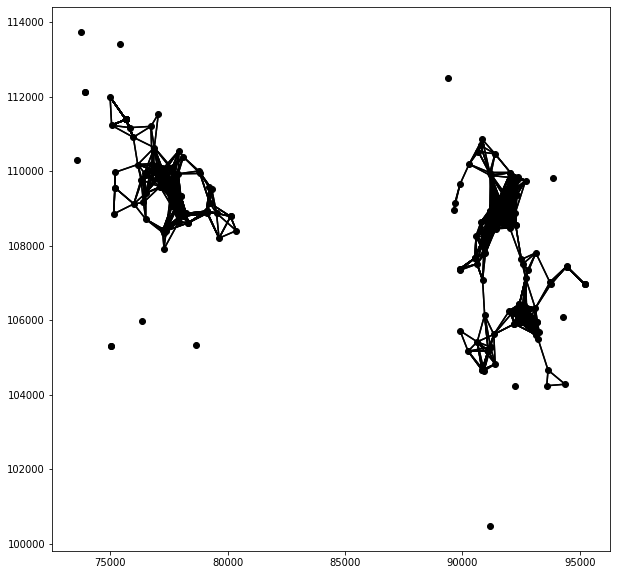

In [285]:
# el método plot permite una representacion grafica
fig, ax = plt.subplots(figsize=(10, 10))
wdistance.plot(gdfEspacial, ax=ax)

In [286]:
#kernelWa = Kernel.from_dataframe(gdfEspacial, k=10, fixed=False, function='gaussian', diagonal=True)


In [287]:
#mi = esda.moran.Moran(gdfEspacial.logprecioxm2, kernelWa)
#mi.I

In [288]:
#plot_moran(mi, zstandard=True, figsize=(10,4))
#plt.show()

In [289]:
#import spreg


In [290]:
#wdistance.transform = 'r'


In [291]:
#name_y="logprecioxm2"
#name_x=["bedrooms"]
#results=spreg.OLS(gdfEspacial.logprecioxm2.values[:, None], gdfEspacial.bedrooms.values[:, None], w=wdistance, spat_diag=True, moran=True, name_y=name_y, name_x=name_x)


In [292]:
#print(results.summary)


Regresiones para medir el efecto en ituzaingó

In [293]:
#gdf.head()

In [294]:
#gdf['DDItuzaingo']=gdf.InicioEPA*gdf.dum_Ituzaingó

In [295]:
#regress(['logprecioxm2','InicioEPA','dum_Ituzaingó','DDItuzaingo'],data=gdf)

In [296]:
#regress(['price','postcovid','airelibre','DD'],data=gdf)

In [297]:
#df.start_date

# Inspección gráfica del cumplimiento del supuesto de tendencias comunes

Vamos a mirar los promedios mensuales y por trimetre. Para eso voy a extraer de la fecha el mes-anio y el trimestre-anio correspondiente.


In [298]:
import pandas as pd
df['monthyear']=pd.to_datetime(df.start_date).dt.to_period('M')

NameError: ignored

In [ ]:
df_months=df.groupby(by=['monthyear','airelibre']).logprice.mean().rename('media').reset_index()
ax=df_months.loc[df_months.airelibre==0].plot(x='monthyear',y='media', label='Sin aire libre')
df_months.loc[df_months.airelibre==1].plot(x='monthyear',y='media', ax=ax, label='Aire libre')

In [ ]:
df['quarteryear']=pd.to_datetime(df.start_date).dt.to_period('Q')
df_quarters=df.groupby(by=['quarteryear','airelibre']).logprice.mean().rename('media').reset_index()
ax=df_quarters.loc[df_quarters.airelibre==0].plot(x='quarteryear',y='media', label='Sin aire libre')
df_quarters.loc[df_quarters.airelibre==1].plot(x='quarteryear',y='media', ax=ax, label='Aire libre')